In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

import joblib

# Economic Development Classification Analysis Using International Monetary Fund World Economic Outlook Data

## Project Group 11

### Team Members

David Blankenship:  dwb65@drexel.edu

Jai Vaidya:         jv625@drexel.edu

# Our Dataset

The dataset that we will be using is the International Monetary Fund (IMF) World Economic Outlook (WEO) dataset. The WEO dataset is a biannual dataset released by the IMF that is used to project economic forecasts in the near and medium term. In addition to the forecast, it's also a great collection of past economic data collected by the IMF. We will be using the latter portion of the dataset. We intend to use this data to perform two different machine learning tasks. The first is supervised, predictive classification of whether a country is a developing/emerging or advanced economy. The second is using the data for unsupervised clustering to determine if there is another classification schema that could reasonably describe the data or see if the advanced and developing/emerging paradigm appears spontaneously from the data.

 We will begin by looking at the initial dataset and the steps we took to get it into a usable format. Further, we will be looking at the data from 2017 to 2021.  The range is chosen for its high proportion of non-null values.

After our initial preprocessing, we will see our datasets shape is 975 by 41; that is 975 instances of country data for those years, 40 features, and 1 target column of 1 or 0 depending on whether the country is an advanced or developing/emerging country.

## Initial Exploration

In [ ]:
filename = './WEOOct2023allfix.xlsx'
df = pd.read_excel(filename, header=0, engine='openpyxl')
df

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1288.87,1021.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,-2.351,-20.737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1547.29,1232.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.136,14.941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,81.007,67.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,1380.14,3187.63,12292.67,111864.93,474084.1,1102309.64,2089955.6,3126416.82,4128929.25,2021.0
8622,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,0.678,0.348,0.321,0.28,-0.317,-0.411,-0.466,-0.512,-0.55,2022.0
8623,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,2.521,0.968,1.019,0.863,-0.673,-0.827,-0.922,-1.081,-1.12,2022.0
8624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index([             'WEO Country Code',                           'ISO',
                    'WEO Subject Code',                       'Country',
                  'Subject Descriptor',                 'Subject Notes',
                               'Units',                         'Scale',
       'Country/Series-specific Notes',                            1980,
                                  1981,                            1982,
                                  1983,                            1984,
                                  1985,                            1986,
                                  1987,                            1988,
                                  1989,                            1990,
                                  1991,                            1992,
                                  1993,                            1994,
                                  1995,                            1996,
                                  1997,            

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8626 entries, 0 to 8625
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   WEO Country Code               8625 non-null   object 
 1   ISO                            8624 non-null   object 
 2   WEO Subject Code               8624 non-null   object 
 3   Country                        8624 non-null   object 
 4   Subject Descriptor             8624 non-null   object 
 5   Subject Notes                  8624 non-null   object 
 6   Units                          8624 non-null   object 
 7   Scale                          3920 non-null   object 
 8   Country/Series-specific Notes  7643 non-null   object 
 9   1980                           3858 non-null   object 
 10  1981                           3988 non-null   object 
 11  1982                           4032 non-null   object 
 12  1983                           4073 non-null   o

In [ ]:
df['WEO Country Code'].unique()

array([512, 914, 612, 171, 614, 311, 213, 911, 314, 193, 122, 912, 313,
       419, 513, 316, 913, 124, 339, 638, 514, 218, 963, 616, 223, 516,
       918, 748, 618, 624, 522, 622, 156, 626, 628, 228, 924, 233, 632,
       636, 634, 238, 662, 960, 423, 935, 128, 611, 321, 243, 248, 469,
       253, 642, 643, 939, 734, 644, 819, 172, 132, 646, 648, 915, 134,
       652, 174, 328, 258, 656, 654, 336, 263, 268, 532, 944, 176, 534,
       536, 429, 433, 178, 436, 136, 343, 158, 439, 916, 664, 826, 542,
       967, 443, 917, 544, 941, 446, 666, 668, 672, 946, 137, 546, 674,
       676, 548, 556, 678, 181, 867, 682, 684, 273, 868, 921, 948, 943,
       686, 688, 518, 728, 836, 558, 138, 196, 278, 692, 694, 962, 142,
       449, 564, 565, 283, 853, 288, 293, 566, 964, 182, 359, 453, 968,
       922, 714, 862, 135, 716, 456, 722, 942, 718, 724, 576, 936, 961,
       813, 726, 199, 733, 184, 524, 361, 362, 364, 732, 366, 144, 146,
       463, 528, 923, 738, 578, 537, 742, 866, 369, 744, 186, 92

In [ ]:
df['ISO'].unique()

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'ABW',
       'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL',
       'BLZ', 'BEN', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR',
       'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CAF', 'TCD', 'CHL',
       'CHN', 'COL', 'COM', 'COD', 'COG', 'CRI', 'CIV', 'HRV', 'CYP',
       'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ',
       'ERI', 'EST', 'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY',
       'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ',
       'IRL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KIR',
       'KOR', 'UVK', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR',
       'LBY', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI',
       'MLT', 'MHL', 'MRT', 'MUS', 'MEX', 'FSM', 'MDA', 'MNG', 'MNE',
       'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NZL', 'NIC',
       'NER', 'NGA',

In [ ]:
# Create Dictionary mapping ISO codes to country names.
# ISO codes are quicker to work with but harder to remember so this dictionary
# is a tool to help us know which country we are looking at.

ISO = df['ISO'].unique()
country_list = df['Country'].unique()
ISO_dict = {ISO[n]: country_list[n] for n in range(len(country_list))}

ISO_dict

{'AFG': 'Afghanistan',
 'ALB': 'Albania',
 'DZA': 'Algeria',
 'AND': 'Andorra',
 'AGO': 'Angola',
 'ATG': 'Antigua and Barbuda',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'ABW': 'Aruba',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BHS': 'The Bahamas',
 'BHR': 'Bahrain',
 'BGD': 'Bangladesh',
 'BRB': 'Barbados',
 'BLR': 'Belarus',
 'BEL': 'Belgium',
 'BLZ': 'Belize',
 'BEN': 'Benin',
 'BTN': 'Bhutan',
 'BOL': 'Bolivia',
 'BIH': 'Bosnia and Herzegovina',
 'BWA': 'Botswana',
 'BRA': 'Brazil',
 'BRN': 'Brunei Darussalam',
 'BGR': 'Bulgaria',
 'BFA': 'Burkina Faso',
 'BDI': 'Burundi',
 'CPV': 'Cabo Verde',
 'KHM': 'Cambodia',
 'CMR': 'Cameroon',
 'CAN': 'Canada',
 'CAF': 'Central African Republic',
 'TCD': 'Chad',
 'CHL': 'Chile',
 'CHN': 'China',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'COD': 'Democratic Republic of the Congo',
 'COG': 'Republic of Congo',
 'CRI': 'Costa Rica',
 'CIV': "Côte d'Ivoire",
 'HRV': 'Croatia',
 'CYP': 'Cyprus',
 'CZE': 'Czech Republic',
 'DNK'

In [ ]:
df['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Democratic Republic of the Congo', 'Republic of Congo',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guate

In [ ]:
len(df['Country'].unique())

197

We see there are 196 countries and one nan value

In [ ]:
df.iloc[8624]

WEO Country Code                 NaN
ISO                              NaN
WEO Subject Code                 NaN
Country                          NaN
Subject Descriptor               NaN
Subject Notes                    NaN
Units                            NaN
Scale                            NaN
Country/Series-specific Notes    NaN
1980                             NaN
1981                             NaN
1982                             NaN
1983                             NaN
1984                             NaN
1985                             NaN
1986                             NaN
1987                             NaN
1988                             NaN
1989                             NaN
1990                             NaN
1991                             NaN
1992                             NaN
1993                             NaN
1994                             NaN
1995                             NaN
1996                             NaN
1997                             NaN
1

In [ ]:
df.iloc[8625]

WEO Country Code                 International Monetary Fund, World Economic Ou...
ISO                                                                            NaN
WEO Subject Code                                                               NaN
Country                                                                        NaN
Subject Descriptor                                                             NaN
Subject Notes                                                                  NaN
Units                                                                          NaN
Scale                                                                          NaN
Country/Series-specific Notes                                                  NaN
1980                                                                           NaN
1981                                                                           NaN
1982                                                                           NaN
1983

We see that we can drop the bottom two rows as they're just nulls.

In [ ]:
df.iloc[8623]

WEO Country Code                                                               698
ISO                                                                            ZWE
WEO Subject Code                                                         BCA_NGDPD
Country                                                                   Zimbabwe
Subject Descriptor                                         Current account balance
Subject Notes                    Current account is all transactions other than...
Units                                                               Percent of GDP
Scale                                                                          NaN
Country/Series-specific Notes    See notes for:  Gross domestic product, curren...
1980                                                                           NaN
1981                                                                           NaN
1982                                                                           NaN
1983

In [ ]:
df = df.iloc[0:8624]

In [ ]:
print(df.shape[0]/len(df['Country'].unique()))

44.0


In [ ]:
df['Country'].value_counts().describe()

count    196.0
mean      44.0
std        0.0
min       44.0
25%       44.0
50%       44.0
75%       44.0
max       44.0
Name: count, dtype: float64

We see here that each country has 44 features. We will create a metadata dataframe with information about the features.

In [ ]:
# Create metadata
metadata_df = df[['Subject Descriptor', 'Subject Notes', 'Units', 'Scale']]

metadata_df

,Subject Descriptor,Subject Notes,Units,Scale
0,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions
1,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN
2,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions
3,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions
4,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions
...,...,...,...,...
8619,General government gross debt,Gross debt consists of all liabilities that re...,National currency,Billions
8620,General government gross debt,Gross debt consists of all liabilities that re...,Percent of GDP,NaN
8621,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions
8622,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions


In [ ]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8624 entries, 0 to 8623
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Subject Descriptor  8624 non-null   object
 1   Subject Notes       8624 non-null   object
 2   Units               8624 non-null   object
 3   Scale               3920 non-null   object
dtypes: object(4)
memory usage: 269.6+ KB


In [ ]:
metadata_df['Subject Descriptor'].value_counts()

Subject Descriptor
Gross domestic product per capita, current prices                                     588
Gross domestic product, current prices                                                588
Gross domestic product, constant prices                                               392
Inflation, end of period consumer prices                                              392
General government gross debt                                                         392
General government net debt                                                           392
General government primary net lending/borrowing                                      392
General government structural balance                                                 392
General government net lending/borrowing                                              392
General government total expenditure                                                  392
General government revenue                                                       

In [ ]:
metadata_df = metadata_df.iloc[0:44,:]
metadata_df

,Subject Descriptor,Subject Notes,Units,Scale
0,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions
1,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN
2,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions
3,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions
4,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions
5,"Gross domestic product, deflator",The GDP deflator is derived by dividing curren...,Index,NaN
6,"Gross domestic product per capita, constant pr...",GDP is expressed in constant national currency...,National currency,Units
7,"Gross domestic product per capita, constant pr...",GDP is expressed in constant international dol...,Purchasing power parity; 2017 international do...,Units
8,"Gross domestic product per capita, current prices",GDP is expressed in current national currency ...,National currency,Units
9,"Gross domestic product per capita, current prices",GDP is expressed in current U.S. dollars per p...,U.S. dollars,Units


We can see that some values are expressed in National currencies. We will convert these to US dollars later. The goal is to ensure we are comparing like to like. For example, without conversion we would be treating a US Dollar and a Japanese Yen as equal in value whereas in reality 1 dollar is roughly equal to 158 yen. This would throw off our comparison by two orders of magnitude!

In [ ]:
df = df[['ISO','Subject Descriptor', 2019]]

df.head()

,ISO,Subject Descriptor,2019
0,AFG,"Gross domestic product, constant prices",1319.9
1,AFG,"Gross domestic product, constant prices",3.912
2,AFG,"Gross domestic product, current prices",1469.6
3,AFG,"Gross domestic product, current prices",18.876
4,AFG,"Gross domestic product, current prices",81.889


In [ ]:
df.head(44)

,ISO,Subject Descriptor,2019
0,AFG,"Gross domestic product, constant prices",1319.9
1,AFG,"Gross domestic product, constant prices",3.912
2,AFG,"Gross domestic product, current prices",1469.6
3,AFG,"Gross domestic product, current prices",18.876
4,AFG,"Gross domestic product, current prices",81.889
5,AFG,"Gross domestic product, deflator",111.341
6,AFG,"Gross domestic product per capita, constant pr...",40990.73
7,AFG,"Gross domestic product per capita, constant pr...",2439.68
8,AFG,"Gross domestic product per capita, current prices",45639.64
9,AFG,"Gross domestic product per capita, current prices",586.204


 We see clearly that there will be a need to impute values in our data.

In [ ]:
#recreating feature names to ensure uniqueness of feature name
metadata_df['Unique Name'] = metadata_df['Subject Descriptor'] + ' in ' + metadata_df['Units']

features = metadata_df['Unique Name']
features


<ipython-input-22-d8c7edafa961>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['Unique Name'] = metadata_df['Subject Descriptor'] + ' in ' + metadata_df['Units']


0     Gross domestic product, constant prices in Nat...
1     Gross domestic product, constant prices in Per...
2     Gross domestic product, current prices in Nati...
3     Gross domestic product, current prices in U.S....
4     Gross domestic product, current prices in Purc...
5             Gross domestic product, deflator in Index
6     Gross domestic product per capita, constant pr...
7     Gross domestic product per capita, constant pr...
8     Gross domestic product per capita, current pri...
9     Gross domestic product per capita, current pri...
10    Gross domestic product per capita, current pri...
11    Output gap in percent of potential GDP in Perc...
12    Gross domestic product based on purchasing-pow...
13    Implied PPP conversion rate in National curren...
14                   Total investment in Percent of GDP
15             Gross national savings in Percent of GDP
16          Inflation, average consumer prices in Index
17    Inflation, average consumer prices in Perc

In [ ]:
# This cell reworks the initial strangely shaped DataFrame into a DataFrame that
# displays country by feature and lets us feed into a ML pipeline
data_store = []
for x in range(196):
    data_store.append(df[2019].iloc[x*44:(x+1)*44].to_numpy())

df_reworked = pd.DataFrame(data_store, index=df['ISO'].unique(),
                           columns=features) # Need to make copied names unique
df_reworked


Unique Name,"Gross domestic product, constant prices in National currency","Gross domestic product, constant prices in Percent change","Gross domestic product, current prices in National currency","Gross domestic product, current prices in U.S. dollars","Gross domestic product, current prices in Purchasing power parity; international dollars","Gross domestic product, deflator in Index","Gross domestic product per capita, constant prices in National currency","Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices in National currency","Gross domestic product per capita, current prices in U.S. dollars",...,General government structural balance in Percent of potential GDP,General government primary net lending/borrowing in National currency,General government primary net lending/borrowing in Percent of GDP,General government net debt in National currency,General government net debt in Percent of GDP,General government gross debt in National currency,General government gross debt in Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices in National currency",Current account balance in U.S. dollars,Current account balance in Percent of GDP
AFG,1319.9,3.912,1469.600,18.876,81.889,111.341,40990.73,2439.68,45639.64,586.204,...,NaN,-14.971,-1.019,NaN,NaN,90.092,6.130,1469.600,2.209,11.705
ALB,837.786,2.088,1691.900,15.399,41.631,201.949,290805.66,13862.63,587280.30,5345.060,...,NaN,3.564,0.211,1023.53,60.496,1139.800,67.368,1691.900,-1.166,-7.571
DZA,7541.49,1.000,20500.200,171.673,509.366,271.832,173670.99,11252.84,472093.77,3953.400,...,NaN,-1850.700,-9.028,6257.39,30.524,9439.600,46.046,20500.200,-16.911,-9.851
AND,2.674,2.016,2.818,3.155,4.553,105.383,34490.03,56330.95,36346.54,40688.490,...,NaN,NaN,NaN,NaN,NaN,0.997,35.365,2.818,0.568,18.010
AGO,1554.7,-0.702,30833.450,84.516,222.480,1983.240,48053.36,6596.76,953014.83,2612.250,...,1.981,1959.870,6.356,NaN,NaN,35012.670,113.554,30833.450,5.137,6.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,4866315.6,7.359,7707200.290,331.818,1023.550,158.379,50436503.44,10176.85,79880604.94,3439.100,...,NaN,76488.370,0.992,NaN,NaN,3141837.300,40.765,7707200.290,12.475,3.759
WBG,61.525,1.363,61.073,17.134,30.503,99.266,12362.59,5879.79,12271.79,3442.750,...,NaN,NaN,NaN,NaN,NaN,21.051,34.469,61.073,-1.779,-10.385
YEM,232.363,2.100,12606.260,21.888,65.121,5425.250,7455.6,2004.46,404484.34,702.286,...,NaN,-712.971,-5.656,11456.13,90.876,11926.670,94.609,12606.260,-1.325,-6.053
ZMB,141.701,1.441,300.449,23.309,64.614,212.029,7709.35,3372.37,16346.08,1268.120,...,NaN,-7.502,-2.497,276.66,92.082,283.702,94.426,300.449,0.101,0.435


In [ ]:
df_reworked.shape

(196, 44)

This is the correct shape as we have 44 features and 196 countries represented in the IMF data

In [ ]:
df_reworked.describe()

Unique Name,"Gross domestic product, constant prices in Percent change","Gross domestic product, current prices in National currency","Gross domestic product, current prices in U.S. dollars","Gross domestic product, current prices in Purchasing power parity; international dollars","Gross domestic product, deflator in Index","Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices in National currency","Gross domestic product per capita, current prices in U.S. dollars","Gross domestic product per capita, current prices in Purchasing power parity; international dollars",Output gap in percent of potential GDP in Percent of potential GDP,...,General government structural balance in Percent of potential GDP,General government primary net lending/borrowing in National currency,General government primary net lending/borrowing in Percent of GDP,General government net debt in National currency,General government net debt in Percent of GDP,General government gross debt in National currency,General government gross debt in Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices in National currency",Current account balance in U.S. dollars,Current account balance in Percent of GDP
count,195.000000,1.950000e+02,195.000000,195.000000,1.950000e+02,195.000000,1.950000e+02,195.000000,195.000000,27.000000,...,83.000000,187.000000,187.000000,9.000000e+01,90.000000,1.930000e+02,193.000000,1.950000e+02,194.000000,194.000000
mean,2.617728,2.977059e+05,447.823338,696.536128,2.261396e+09,21554.852821,3.817869e+06,14957.799815,22468.977436,0.450778,...,-2.304855,-5454.507353,-0.373299,1.812146e+05,43.128611,1.299407e+05,57.499285,2.977056e+05,1.947773,-2.197567
std,3.791292,2.323566e+06,1925.839943,2461.798654,3.157867e+10,22242.270811,2.488331e+07,19920.391727,23185.548150,1.765325,...,3.884044,71176.235791,4.447708,1.153240e+06,35.271414,1.010077e+06,38.091333,2.323566e+06,45.172325,10.946994
min,-27.670000,7.800000e-02,0.054000,0.053000,8.138600e+01,425.947000,3.614900e+01,261.294000,444.011000,-6.078000,...,-21.643000,-967997.310000,-25.321000,-9.671230e+03,-74.200000,0.000000e+00,0.000000,7.800000e-02,-441.750000,-68.779000
25%,1.141500,6.175250e+01,9.882500,24.974000,1.043345e+02,5065.605000,2.336694e+04,2192.040000,5280.430000,0.263000,...,-3.677500,-39.028000,-2.209000,2.428125e+01,25.454750,2.465100e+01,36.629000,6.175250e+01,-1.643250,-5.845750
50%,2.683000,7.755710e+02,37.925000,84.968000,1.142740e+02,13637.870000,7.184046e+04,6073.000000,14216.240000,0.600000,...,-1.707000,-0.297000,-0.455000,2.945025e+02,40.720000,3.896620e+02,48.867000,7.755710e+02,-0.292000,-2.068500
75%,4.619500,8.326050e+03,236.285500,416.088000,1.536185e+02,32998.150000,5.192996e+05,19105.150000,34397.580000,1.068500,...,0.037000,4.158000,1.406500,2.686840e+03,54.678750,4.481950e+03,70.635000,8.326050e+03,0.818750,2.822500
max,13.822000,2.736401e+07,21380.950000,23360.810000,4.409722e+11,119940.000000,3.293893e+08,113860.530000,125026.560000,5.000000,...,4.138000,76488.370000,18.639000,1.009949e+07,167.061000,1.276832e+07,260.393000,2.736401e+07,317.797000,49.473000


There's something weird going on in this. Not all columns are showing up. This has to do with the columns that are objects vice float64's. We will see that this is because Venezuela's data has strings inserted in these columns.

### Inspecting Null Values

We will review features which are missing an extreme amount of values or only missing a few values. These are relatively straightforward to fix and easy to determine the issue. The ones somewhere in between will require more effort to determine why they are missing and/or fix. This will be done when we get to imputation and feature selection/engineering.

In [ ]:
df_reworked.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, AFG to ZWE
Data columns (total 44 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   Gross domestic product, constant prices in National currency                                              195 non-null    object 
 1   Gross domestic product, constant prices in Percent change                                                 195 non-null    float64
 2   Gross domestic product, current prices in National currency                                               195 non-null    float64
 3   Gross domestic product, current prices in U.S. dollars                                                    195 non-null    float64
 4   Gross domestic product, current prices in Purchasing power parity; international do

In [ ]:
df_reworked.loc['VEN']

Unique Name
Gross domestic product, constant prices in National currency                                                                --
Gross domestic product, constant prices in Percent change                                                               -27.67
Gross domestic product, current prices in National currency                                                              1.006
Gross domestic product, current prices in U.S. dollars                                                                  73.003
Gross domestic product, current prices in Purchasing power parity; international dollars                               227.234
Gross domestic product, deflator in Index                                                                   440972168070.27002
Gross domestic product per capita, constant prices in National currency                                                     --
Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international d

As mentioned earlier we see that Venezuela gives strings for certain features. We will fix this later.

In [ ]:
df_reworked['Gross domestic product, constant prices in National currency'][df_reworked['Gross domestic product, constant prices in National currency'].isnull()]

SYR    NaN
Name: Gross domestic product, constant prices in National currency, dtype: object

In [ ]:
df_reworked.loc['SYR']

Unique Name
Gross domestic product, constant prices in National currency                                                NaN
Gross domestic product, constant prices in Percent change                                                   NaN
Gross domestic product, current prices in National currency                                                 NaN
Gross domestic product, current prices in U.S. dollars                                                      NaN
Gross domestic product, current prices in Purchasing power parity; international dollars                    NaN
Gross domestic product, deflator in Index                                                                   NaN
Gross domestic product per capita, constant prices in National currency                                     NaN
Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar    NaN
Gross domestic product per capita, current prices in National currency                      

Data for Syria hasn't been collected since the start of the Syrian Civil War in 2011. As such, theres no realistic way for us to impute this and we will be dropping Syria as a result.

In [ ]:
df_reworked['Current account balance in U.S. dollars'][df_reworked['Current account balance in U.S. dollars'].isnull()]

PRI   NaN
SYR   NaN
Name: Current account balance in U.S. dollars, dtype: float64

In [ ]:
df_reworked['Current account balance in Percent of GDP'][df_reworked['Current account balance in Percent of GDP'].isnull()]

PRI   NaN
SYR   NaN
Name: Current account balance in Percent of GDP, dtype: float64

In [ ]:
ISO_dict['PRI']

'Puerto Rico'

Apparently, Puerto Rico simply doesn't collect, or at least report on, this data. World Bank also does not have this. We will have to impute this.

In [ ]:
df_reworked.loc['PRI']

Unique Name
Gross domestic product, constant prices in National currency                                                   9.627
Gross domestic product, constant prices in Percent change                                                      1.679
Gross domestic product, current prices in National currency                                                  105.126
Gross domestic product, current prices in U.S. dollars                                                       105.126
Gross domestic product, current prices in Purchasing power parity; international dollars                     115.831
Gross domestic product, deflator in Index                                                                    1091.99
Gross domestic product per capita, constant prices in National currency                                      3008.44
Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar    34724.61
Gross domestic product per capita, current prices in

In [ ]:
df_reworked['Output gap in percent of potential GDP in Percent of potential GDP'][df_reworked['Output gap in percent of potential GDP in Percent of potential GDP'].isnull() == False]

AUS   -1.010
AUT    0.774
BEL    1.828
CAN    0.358
CYP    1.242
DNK    0.851
EST    2.011
FIN    0.479
FRA    0.000
DEU    0.357
GRC   -6.078
IRL    0.467
ITA   -1.518
JPN    0.673
KOR   -0.701
LUX    0.326
MLT    5.000
NLD    0.600
NZL    0.888
NOR    0.200
PRT    1.397
SVK    1.118
SVN    1.019
ESP    0.442
SWE    1.584
GBR   -0.809
USA    0.673
Name: Output gap in percent of potential GDP in Percent of potential GDP, dtype: float64

In [ ]:
ISO_dict['AUT']

'Austria'

Output gap is apparently only calculated for certain advanced economies and is itself a somewhat controversial measurement amongst economists. As such we will be dropping it as there is no way to realistically obtain it.

In [ ]:
df_reworked['Total investment in Percent of GDP'][df_reworked['Total investment in Percent of GDP'].isnull()]

AND   NaN
ABW   NaN
IRQ   NaN
KIR   NaN
LAO   NaN
LBN   NaN
LBR   NaN
MHL   NaN
FSM   NaN
NRU   NaN
MKD   NaN
PNG   NaN
QAT   NaN
WSM   NaN
SOM   NaN
SDN   NaN
SUR   NaN
SYR   NaN
TON   NaN
TTO   NaN
TKM   NaN
TUV   NaN
VEN   NaN
ZWE   NaN
Name: Total investment in Percent of GDP, dtype: float64

In [ ]:
df_reworked['Gross national savings in Percent of GDP'][df_reworked['Gross national savings in Percent of GDP'].isnull()]

AND   NaN
BRN   NaN
FJI   NaN
KIR   NaN
LAO   NaN
LBR   NaN
LBY   NaN
MAC   NaN
MHL   NaN
FSM   NaN
NRU   NaN
PLW   NaN
PNG   NaN
PRI   NaN
WSM   NaN
SMR   NaN
SOM   NaN
SYR   NaN
TLS   NaN
TON   NaN
TKM   NaN
TUV   NaN
VUT   NaN
VEN   NaN
WBG   NaN
ZWE   NaN
Name: Gross national savings in Percent of GDP, dtype: float64

In [ ]:
df_reworked['Employment in Persons'][df_reworked['Employment in Persons'].isnull() == False]

AND      0.045
AUS     12.859
AUT      4.355
BEL      4.979
CAN     19.114
HRV      1.533
CYP      0.416
CZE      5.117
DNK      2.886
EST      0.671
FIN      2.533
FRA     27.389
DEU     41.597
GRC      3.911
HKG      3.871
ISL      0.195
IRL      2.319
ISR      3.967
ITA     23.109
JPN     67.240
KOR     27.123
LVA      0.910
LTU      1.378
LUX      0.463
MAC      0.388
MLT      0.255
NLD      9.117
NZL      2.695
NOR      2.725
PRT      4.980
PRI      0.990
SGP      3.753
SVK      2.445
SVN      1.046
ESP     19.779
SWE      5.074
CHE      5.101
TWN     11.501
GBR     32.799
USA    157.534
Name: Employment in Persons, dtype: float64

This is just a list of advanced economies. Economies not classified as advanced dont track this. We will be dropping this feature as we cannot use it.

In [ ]:
df_reworked['Unemployment rate in Percent of total labor force'][df_reworked['Unemployment rate in Percent of total labor force'].isnull()].index

Index(['AFG', 'AGO', 'ATG', 'BGD', 'BEN', 'BWA', 'BFA', 'BDI', 'KHM', 'CMR',
       'CAF', 'TCD', 'COM', 'COD', 'COG', 'CIV', 'DJI', 'DMA', 'GNQ', 'ERI',
       'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY',
       'HTI', 'IND', 'IRQ', 'KEN', 'KIR', 'LAO', 'LBN', 'LSO', 'LBR', 'LBY',
       'MDG', 'MWI', 'MDV', 'MLI', 'MHL', 'MRT', 'FSM', 'MNE', 'MOZ', 'MMR',
       'NAM', 'NRU', 'NPL', 'NER', 'NGA', 'OMN', 'PLW', 'PNG', 'QAT', 'RWA',
       'WSM', 'STP', 'SEN', 'SLE', 'SLB', 'SOM', 'SSD', 'KNA', 'LCA', 'VCT',
       'SYR', 'TJK', 'TZA', 'TLS', 'TGO', 'TON', 'TTO', 'TKM', 'TUV', 'UGA',
       'ARE', 'VUT', 'VEN', 'YEM', 'ZMB', 'ZWE'],
      dtype='object')

Will need to look if its just that year missing.

In [ ]:
nan_by_country = df_reworked.isnull().sum(axis=1)
with pd.option_context('display.max_rows', None):
    display(nan_by_country)

AFG     7
ALB     4
DZA     4
AND    13
AGO     5
ATG     7
ARG     4
ARM     6
ABW    11
AUS     0
AUT     0
AZE     6
BHS     6
BHR     6
BGD     7
BRB     2
BLR     4
BEL     0
BLZ     6
BEN     7
BTN     6
BOL     4
BIH     2
BWA     3
BRA     2
BRN     7
BGR     2
BFA     7
BDI     7
CPV     4
KHM     7
CMR     5
CAN     0
CAF     7
TCD     7
CHL     2
CHN     4
COL     2
COM     7
COD     7
COG     7
CRI     4
CIV     7
HRV     1
CYP     0
CZE     1
DNK     0
DJI     5
DMA     7
DOM     2
ECU     4
EGY     2
SLV     4
GNQ     5
ERI     7
EST     0
SWZ     5
ETH     5
FJI     9
FIN     0
FRA     0
GAB     7
GMB     6
GEO     4
DEU     0
GHA     5
GRC     2
GRD     5
GTM     5
GIN     7
GNB     7
GUY     3
HTI     7
HND     6
HKG     3
HUN     2
ISL     1
IND     5
IDN     2
IRN     4
IRQ    12
IRL     0
ISR     1
ITA     0
JAM     6
JPN     0
JOR     2
KAZ     2
KEN     5
KIR     9
KOR     0
UVK     4
KWT     8
KGZ     6
LAO     9
LVA     1
LBN     4
LSO     5
LBR     7
LBY    10


## EDA

In the prior section we reshaped the data into a usable format and determined the need to drop Syria and certain features due to being values we would not be able to impute.

Here we will begin our proper EDA by creating the full DataFrame we will use and continue on to the analysis.

In [ ]:
filename = './WEOOct2023allfix.xlsx'

In [ ]:
raw_df = pd.read_excel(filename, header=0, engine='openpyxl')
raw_df = raw_df.iloc[0:8624] # dropping rows of nans

In [ ]:
# Mapping ISO to Country Name
ISO = raw_df['ISO'].unique()
country_list = raw_df['Country'].unique()
ISO_dict = {ISO[n]: country_list[n] for n in range(len(country_list))}

ISO_dict

{'AFG': 'Afghanistan',
 'ALB': 'Albania',
 'DZA': 'Algeria',
 'AND': 'Andorra',
 'AGO': 'Angola',
 'ATG': 'Antigua and Barbuda',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'ABW': 'Aruba',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BHS': 'The Bahamas',
 'BHR': 'Bahrain',
 'BGD': 'Bangladesh',
 'BRB': 'Barbados',
 'BLR': 'Belarus',
 'BEL': 'Belgium',
 'BLZ': 'Belize',
 'BEN': 'Benin',
 'BTN': 'Bhutan',
 'BOL': 'Bolivia',
 'BIH': 'Bosnia and Herzegovina',
 'BWA': 'Botswana',
 'BRA': 'Brazil',
 'BRN': 'Brunei Darussalam',
 'BGR': 'Bulgaria',
 'BFA': 'Burkina Faso',
 'BDI': 'Burundi',
 'CPV': 'Cabo Verde',
 'KHM': 'Cambodia',
 'CMR': 'Cameroon',
 'CAN': 'Canada',
 'CAF': 'Central African Republic',
 'TCD': 'Chad',
 'CHL': 'Chile',
 'CHN': 'China',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'COD': 'Democratic Republic of the Congo',
 'COG': 'Republic of Congo',
 'CRI': 'Costa Rica',
 'CIV': "Côte d'Ivoire",
 'HRV': 'Croatia',
 'CYP': 'Cyprus',
 'CZE': 'Czech Republic',
 'DNK'

In [ ]:
# Use to add a developed/developing column for target. ie 1 or 0.
advanced_economies = ['Andorra', 'Australia', 'Austria', 'Belgium', 'Canada', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
                      'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong SAR', 'Iceland', 'Ireland', 'Israel', 'Italy',
                      'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Macao SAR', 'Malta', 'Netherlands', 'New Zealand',
                      'Norway', 'Portugal', 'Puerto Rico', 'San Marino', 'Singapore', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden',
                      'Switzerland', 'Taiwan Province of China', 'United Kingdom', 'United States']

In [ ]:
len(advanced_economies)

41

The IMF classifies certain countries as advanced or emerging/developing. We take these classifiers from the IMF.

In [ ]:
# Creating binary target
target_dict = {}
for key in ISO_dict:
    if ISO_dict[key] in advanced_economies:
        target_dict[key] = 1
    else:
        target_dict[key] = 0


In [ ]:
# Useful functions developed for EDA.

def rename_mapper(df, list_to_rename, new_names):
    '''
    For use in df_IMF_oneyear. Renames columns after unit conversion to dollars
    '''
    rename_map = {}
    for i in range(len(list_to_rename)):
        rename_map[list_to_rename[i]] = new_names[i]
    return df.rename(columns=rename_map)

def df_IMF_oneyear(raw_df, year, target_dict):
    '''
    This creates a DataFrame from the IMF WEO dataset for a single year,
    reshapes it into a usable format, adds target information, drops rows of
    marginal value, converts National Currencies into US Dollar values, and
    gives us a metadata DataFrame.

    This will feed into a larger Dataframe of multiple years.
    '''

    # create metadata and unique feature names for final df
    metadata_df = raw_df[['Subject Descriptor', 'Subject Notes', 'Units', 'Scale']].iloc[0:44, :]
    metadata_df['Unique Name'] = metadata_df['Subject Descriptor'] + ' in ' + metadata_df['Units']
    features = metadata_df['Unique Name']

    # create year slice of df
    df = raw_df[['ISO','Subject Descriptor', year]]

    data_store = []
    for x in range(196):
        data_store.append(df[year].iloc[x*44:(x+1)*44].to_numpy())

    df_reworked = pd.DataFrame(data_store, index=df['ISO'].unique(), columns=features)

    # Add targets 1 for Advanced 0 for Developing
    df_reworked['target'] = list(target_dict.values())

    # Drop rows and columns as explored above
    df_reworked.drop(labels='SYR', axis=0, inplace=True)
    df_reworked.drop(labels=['Gross domestic product per capita, current prices in National currency',
                             'Output gap in percent of potential GDP in Percent of potential GDP',
                            'Employment in Persons'], axis=1, inplace=True) # May need to add more later

    # Venezuela's data had a string as opposed to NaN in certain places. This fixes it as well as the dtype of the column.
    df_reworked.replace(to_replace='--', value=np.nan, inplace=True)


    # Perform unit conversions to US dollar
    # Value in US dollars = Value in National Currency * (GDP in dollars / GDP in National Currency)
    conversion_list = ['Gross domestic product, constant prices in National currency',
                       'Gross domestic product per capita, constant prices in National currency',
                       'General government revenue in National currency',
                       'General government total expenditure in National currency',
                       'General government net lending/borrowing in National currency',
                       'General government structural balance in National currency',
                       'General government primary net lending/borrowing in National currency',
                       'General government net debt in National currency',
                       'General government gross debt in National currency',
                       'Gross domestic product corresponding to fiscal year, current prices in National currency'
                      ]

    conversion_rate = df_reworked['Gross domestic product, current prices in U.S. dollars'] / df_reworked['Gross domestic product, current prices in National currency']

    # Applies conversion
    for value in conversion_list:
        df_reworked[value] = df_reworked[value] * conversion_rate

        rename_list = ['Gross domestic product, constant prices in US dollars',
                       'Gross domestic product per capita, constant prices in US dollars',
                       'General government revenue in US dollars',
                       'General government total expenditure in US dollars',
                       'General government net lending/borrowing in US dollars',
                       'General government structural balance in US dollars',
                       'General government primary net lending/borrowing in US dollars',
                       'General government net debt in US dollars',
                       'General government gross debt in US dollars',
                       'Gross domestic product corresponding to fiscal year, current prices in US dollars'
                      ]

    # Rename columns to reflect new units
    rename_mapper = {}
    for i in range(len(rename_list)):
        rename_mapper[conversion_list[i]] = rename_list[i]
    df_reworked.rename(columns=rename_mapper, inplace=True)

    # Drop Gross domestic product, current prices in National currency after conversion due to it being extraeneous.
    df_reworked.drop(labels='Gross domestic product, current prices in National currency', axis=1, inplace=True)


    return df_reworked, metadata_df # Need to rework Metadata df to reflect changes to DF

def df_IMF_full(raw_df, year_range, target_dict):
    '''
    This function will create a Dataframe of the IMF WEO data for several years.
    It creates unique indices by using the country ISO and year
    For example: USA 2017 could be an index name.
    '''

    first = False
    for year in year_range:
        oneyear_df, metadata_df = df_IMF_oneyear(raw_df, year, target_dict)

        new_index = oneyear_df.index + ' ' + str(year)
        oneyear_df.index = new_index

        if not first:
          full_df = oneyear_df.copy()
          first = True
        else:
          full_df = pd.concat([full_df, oneyear_df])

    return full_df


### Analysis



In [ ]:
## We need to determine our year range. We should be concerned about economic growth throwing off the comparison.
full_df = df_IMF_full(raw_df, [2017, 2018, 2019, 2020, 2021], target_dict)
full_df

Unique Name,"Gross domestic product, constant prices in US dollars","Gross domestic product, constant prices in Percent change","Gross domestic product, current prices in U.S. dollars","Gross domestic product, current prices in Purchasing power parity; international dollars","Gross domestic product, deflator in Index","Gross domestic product per capita, constant prices in US dollars","Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices in U.S. dollars","Gross domestic product per capita, current prices in Purchasing power parity; international dollars",Gross domestic product based on purchasing-power-parity (PPP) share of world total in Percent,...,General government primary net lending/borrowing in US dollars,General government primary net lending/borrowing in Percent of GDP,General government net debt in US dollars,General government net debt in Percent of GDP,General government gross debt in US dollars,General government gross debt in Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices in US dollars",Current account balance in U.S. dollars,Current account balance in Percent of GDP,target
AFG 2017,18.439812,2.647,18.883,74.712,102.404,620.867828,2515.55,635.789,2515.55,0.061,...,-0.114095,-0.604,NaN,NaN,1.510202,7.998,18.883,1.431,7.576,0
ALB 2017,6.641133,3.802,13.053,37.609,196.547,2302.614606,13039.70,4525.890,13039.70,0.031,...,0.085095,0.652,8.550340,65.505,9.384372,71.895,13.053,-0.978,-7.492,0
DZA 2017,66.530313,1.400,167.498,478.068,251.762,1594.648371,11458.70,4014.710,11458.70,0.390,...,-12.815120,-7.651,36.146915,21.580,45.629785,27.242,167.498,-22.331,-13.332,0
AND 2017,2.908484,0.346,2.993,4.215,102.912,38880.873012,56352.20,40017.740,56352.20,0.003,...,NaN,NaN,NaN,NaN,1.132517,37.854,2.993,NaN,NaN,1
AGO 2017,9.562574,-0.150,122.022,217.805,1276.040,316.550576,7210.03,4039.300,7210.03,0.178,...,-3.615948,-2.963,NaN,NaN,84.589167,69.323,122.022,-0.633,-0.519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM 2021,223.855231,2.560,369.736,1143.070,165.167,2272.498902,10516.21,3753.430,11604.08,0.771,...,-0.861411,-0.233,NaN,NaN,144.602791,39.110,369.736,-8.150,-2.204,0
WBG 2021,18.075256,7.012,18.109,30.642,100.186,3457.919370,5312.50,3464.380,5862.06,0.021,...,NaN,NaN,NaN,NaN,9.086386,50.176,18.109,-1.778,-9.818,0
YEM 2021,0.203280,-1.000,19.263,62.444,9476.070,6.227766,1733.71,590.136,1913.05,0.042,...,0.043460,0.226,13.889348,72.104,14.336720,74.426,19.263,-2.972,-15.430,0
ZMB 2021,7.197968,4.599,22.148,69.551,307.698,369.636044,3236.80,1137.340,3571.64,0.047,...,-0.453289,-2.047,24.185950,109.201,24.537731,110.790,22.148,2.138,9.652,0


In [ ]:
full_df.shape

(975, 41)

In [ ]:
full_df.describe()

Unique Name,"Gross domestic product, constant prices in US dollars","Gross domestic product, constant prices in Percent change","Gross domestic product, current prices in U.S. dollars","Gross domestic product, current prices in Purchasing power parity; international dollars","Gross domestic product, deflator in Index","Gross domestic product per capita, constant prices in US dollars","Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices in U.S. dollars","Gross domestic product per capita, current prices in Purchasing power parity; international dollars",Gross domestic product based on purchasing-power-parity (PPP) share of world total in Percent,...,General government primary net lending/borrowing in US dollars,General government primary net lending/borrowing in Percent of GDP,General government net debt in US dollars,General government net debt in Percent of GDP,General government gross debt in US dollars,General government gross debt in Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices in US dollars",Current account balance in U.S. dollars,Current account balance in Percent of GDP,target
count,968.000000,973.000000,973.000000,973.000000,9.730000e+02,968.000000,973.000000,973.000000,973.000000,938.000000,...,931.000000,932.000000,450.000000,450.000000,961.000000,962.000000,972.000000,965.000000,965.000000,975.000000
mean,395.775715,1.874994,448.051829,688.379819,1.298660e+11,13466.696688,21036.845409,14839.785083,21986.584314,0.533027,...,-16.600887,-1.787804,495.329809,46.652122,403.778081,60.830340,448.456645,2.386238,-2.231540,0.210256
std,1731.767004,6.471012,1927.136720,2446.649943,3.759790e+12,19686.027537,21706.232410,20096.593604,22706.258886,1.849400,...,132.490056,5.257512,2171.205432,39.073756,2139.758990,40.439748,1928.094086,53.693126,9.862151,0.407700
min,0.030052,-54.236000,0.045000,0.044000,5.910900e+01,1.086538,386.686000,143.345000,408.346000,0.001000,...,-2515.770000,-36.640000,-418.224369,-85.301000,0.000000,0.000000,0.045000,-831.445000,-68.779000,0.000000
25%,4.759780,-0.150000,9.515000,23.766000,1.039860e+02,1197.618809,4983.470000,2181.870000,5182.730000,0.020000,...,-2.152399,-4.007500,5.856096,24.195250,3.760949,37.612500,9.491250,-1.896000,-6.572000,0.000000
50%,23.357598,2.806000,36.927000,82.079000,1.135830e+02,4288.895972,13171.300000,5859.280000,13841.530000,0.073500,...,-0.241906,-1.450500,34.391194,43.059500,16.393213,52.410000,36.912000,-0.286000,-2.116000,0.000000
75%,186.196044,4.889000,228.848000,402.126000,1.546310e+02,16731.365064,31773.680000,18552.180000,33326.040000,0.329500,...,0.044375,0.569250,194.776287,60.543000,108.512562,74.264000,229.740750,0.759000,2.415000,0.000000
max,19609.800000,43.480000,23315.080000,27419.470000,1.169441e+14,118781.289269,125279.310000,134925.160000,132472.340000,18.505000,...,106.252697,40.546000,22921.360000,346.403000,29474.080000,349.877000,23315.080000,352.886000,60.922000,1.000000


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, AFG 2017 to ZWE 2021
Data columns (total 41 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   Gross domestic product, constant prices in US dollars                                                     968 non-null    float64
 1   Gross domestic product, constant prices in Percent change                                                 973 non-null    float64
 2   Gross domestic product, current prices in U.S. dollars                                                    973 non-null    float64
 3   Gross domestic product, current prices in Purchasing power parity; international dollars                  973 non-null    float64
 4   Gross domestic product, deflator in Index                                

We will need to review features missing large a % of their dataset and consider if worth keeping these features. In particular, if they are consistently missing for the same countries year after year it may not be possible to impute them. Ideally, we would like to keep these and find a way to impute. These features are listed below.

Unemployment rate in Percent of total labor force,
General government structural balance in US dollars,
General government structural balance in Percent of potential GDP,
General government net debt in US dollars,
General government net debt in Percent of GDP,
General government structural balance in Percent of potential GDP

In [ ]:
print('Fraction of dataset the IMF classifies as advanced economies: ', full_df['target'][full_df['target'] == 1].count() / full_df.shape[0])

print('Fraction of dataset the IMF classifies as Developing/Emerging economies: ', full_df['target'][full_df['target'] == 0].count() /  full_df.shape[0])

Fraction of dataset the IMF classifies as advanced economies:  0.21025641025641026
Fraction of dataset the IMF classifies as Developing/Emerging economies:  0.7897435897435897


The target is skewed in favor of developing economies by about 4:1. We elect to stratify on the target.

In [ ]:
# Length of feature names is causing the displays to be very poor.
# We do this make the charts display better

col_names = full_df.columns.tolist()
new_names = ['x' + str(i) for i in range(len(col_names)-1)]+['y']

df_easynames = rename_mapper(full_df, col_names, new_names)
df_easynames.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'y'],
      dtype='object', name='Unique Name')

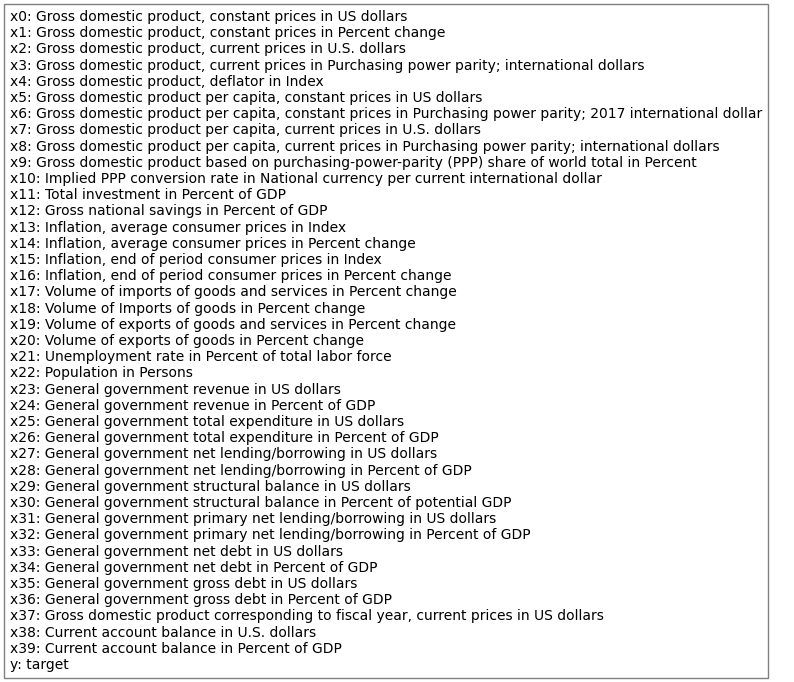

In [ ]:
# Create a textbox to explain the meaning of x0, x1....x39, y.
plt.figure(figsize=(10, 6))
textbox_content = '\n'.join(f'{new_name}: {original_name}' for new_name, original_name in zip(new_names, col_names))
plt.text(0, 0.5, textbox_content, fontsize=10, verticalalignment='center', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
plt.axis('off')
plt.show()

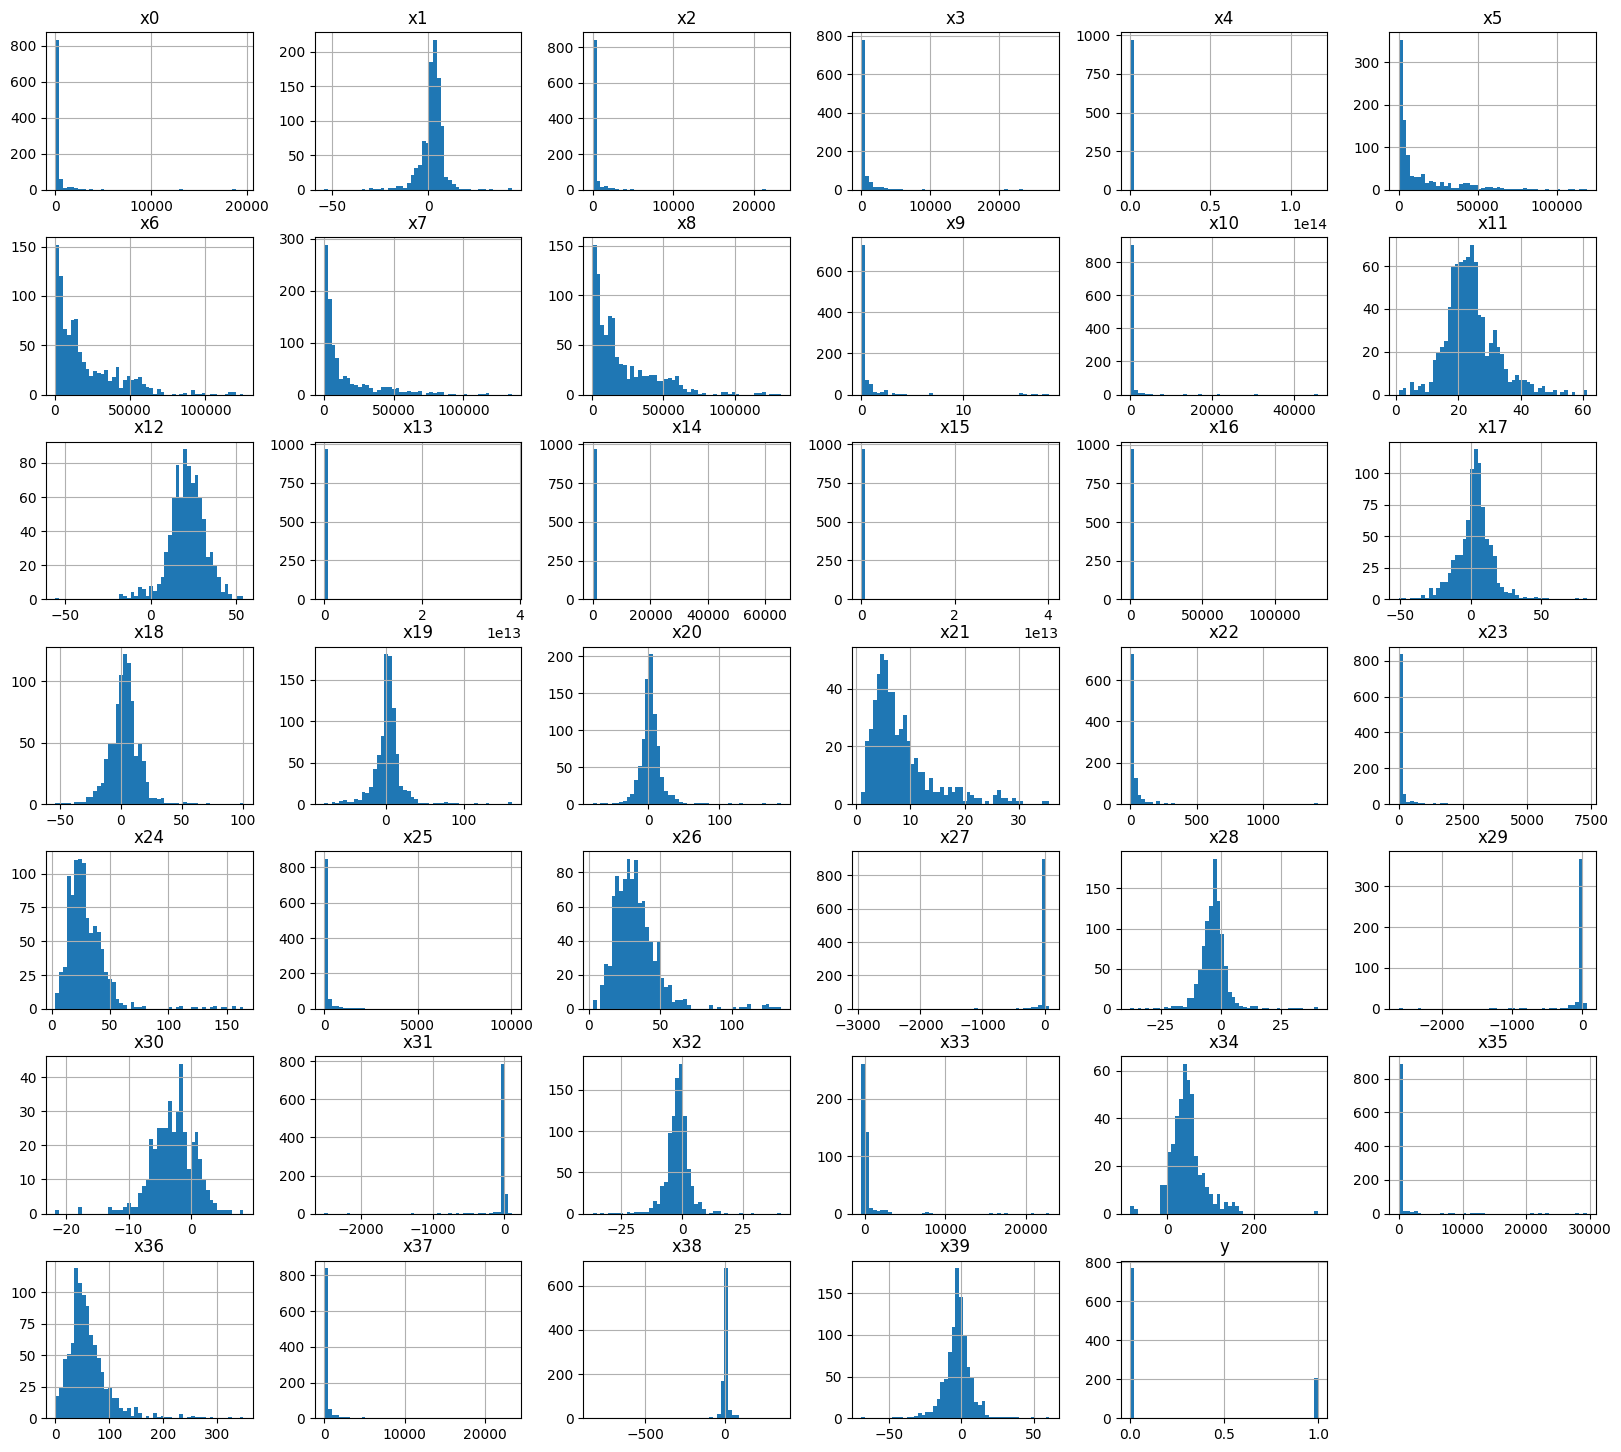

In [ ]:
#Plot the histograms
df_easynames.hist(bins=50, figsize=(20,18))
plt.show()

We see here a mix of characteristics for different features. While many have gaussian-like distributions others are skewed, sometimes extremely so. We elect to utilize log transformations where possible.

We also see that different scalers will be very necessary as the features have a wide variance in range.

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


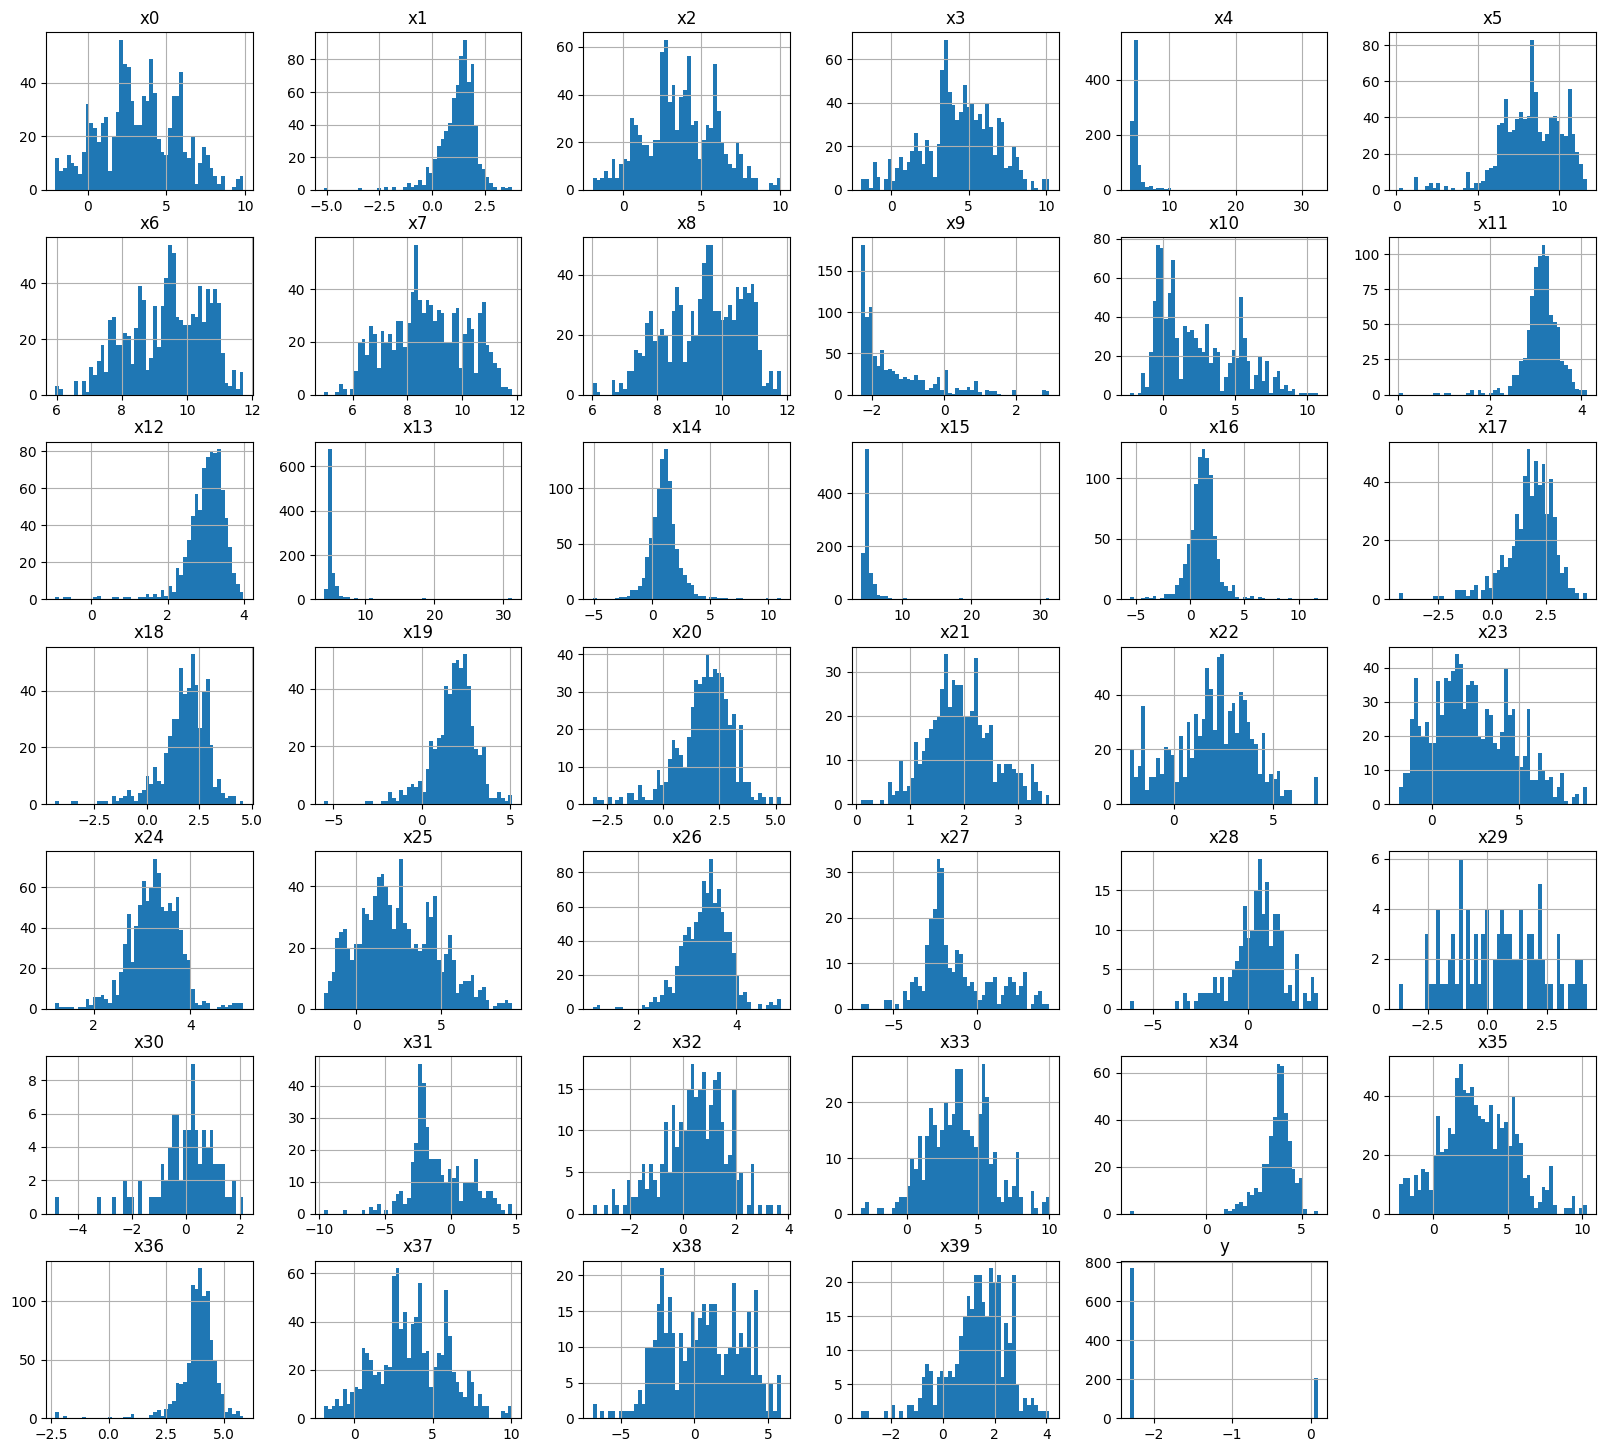

In [ ]:
df_easynames_log = np.log(df_easynames+0.1)

df_easynames_log.hist(bins=50, figsize=(20,18))
plt.show()


We can see from the above charts that several features should be transformed into a log space.

They are the following features: x0, x2, x3, x5, x6, x7, x8, x9, x10, x14, x16, x21, x22, x23, x25, x26, x35, x37.

### Correlations

We will probably need to do feature selection or at least should consider it. We see in the correlation matrix, and from simply understanding the features, that many are highly correlated.

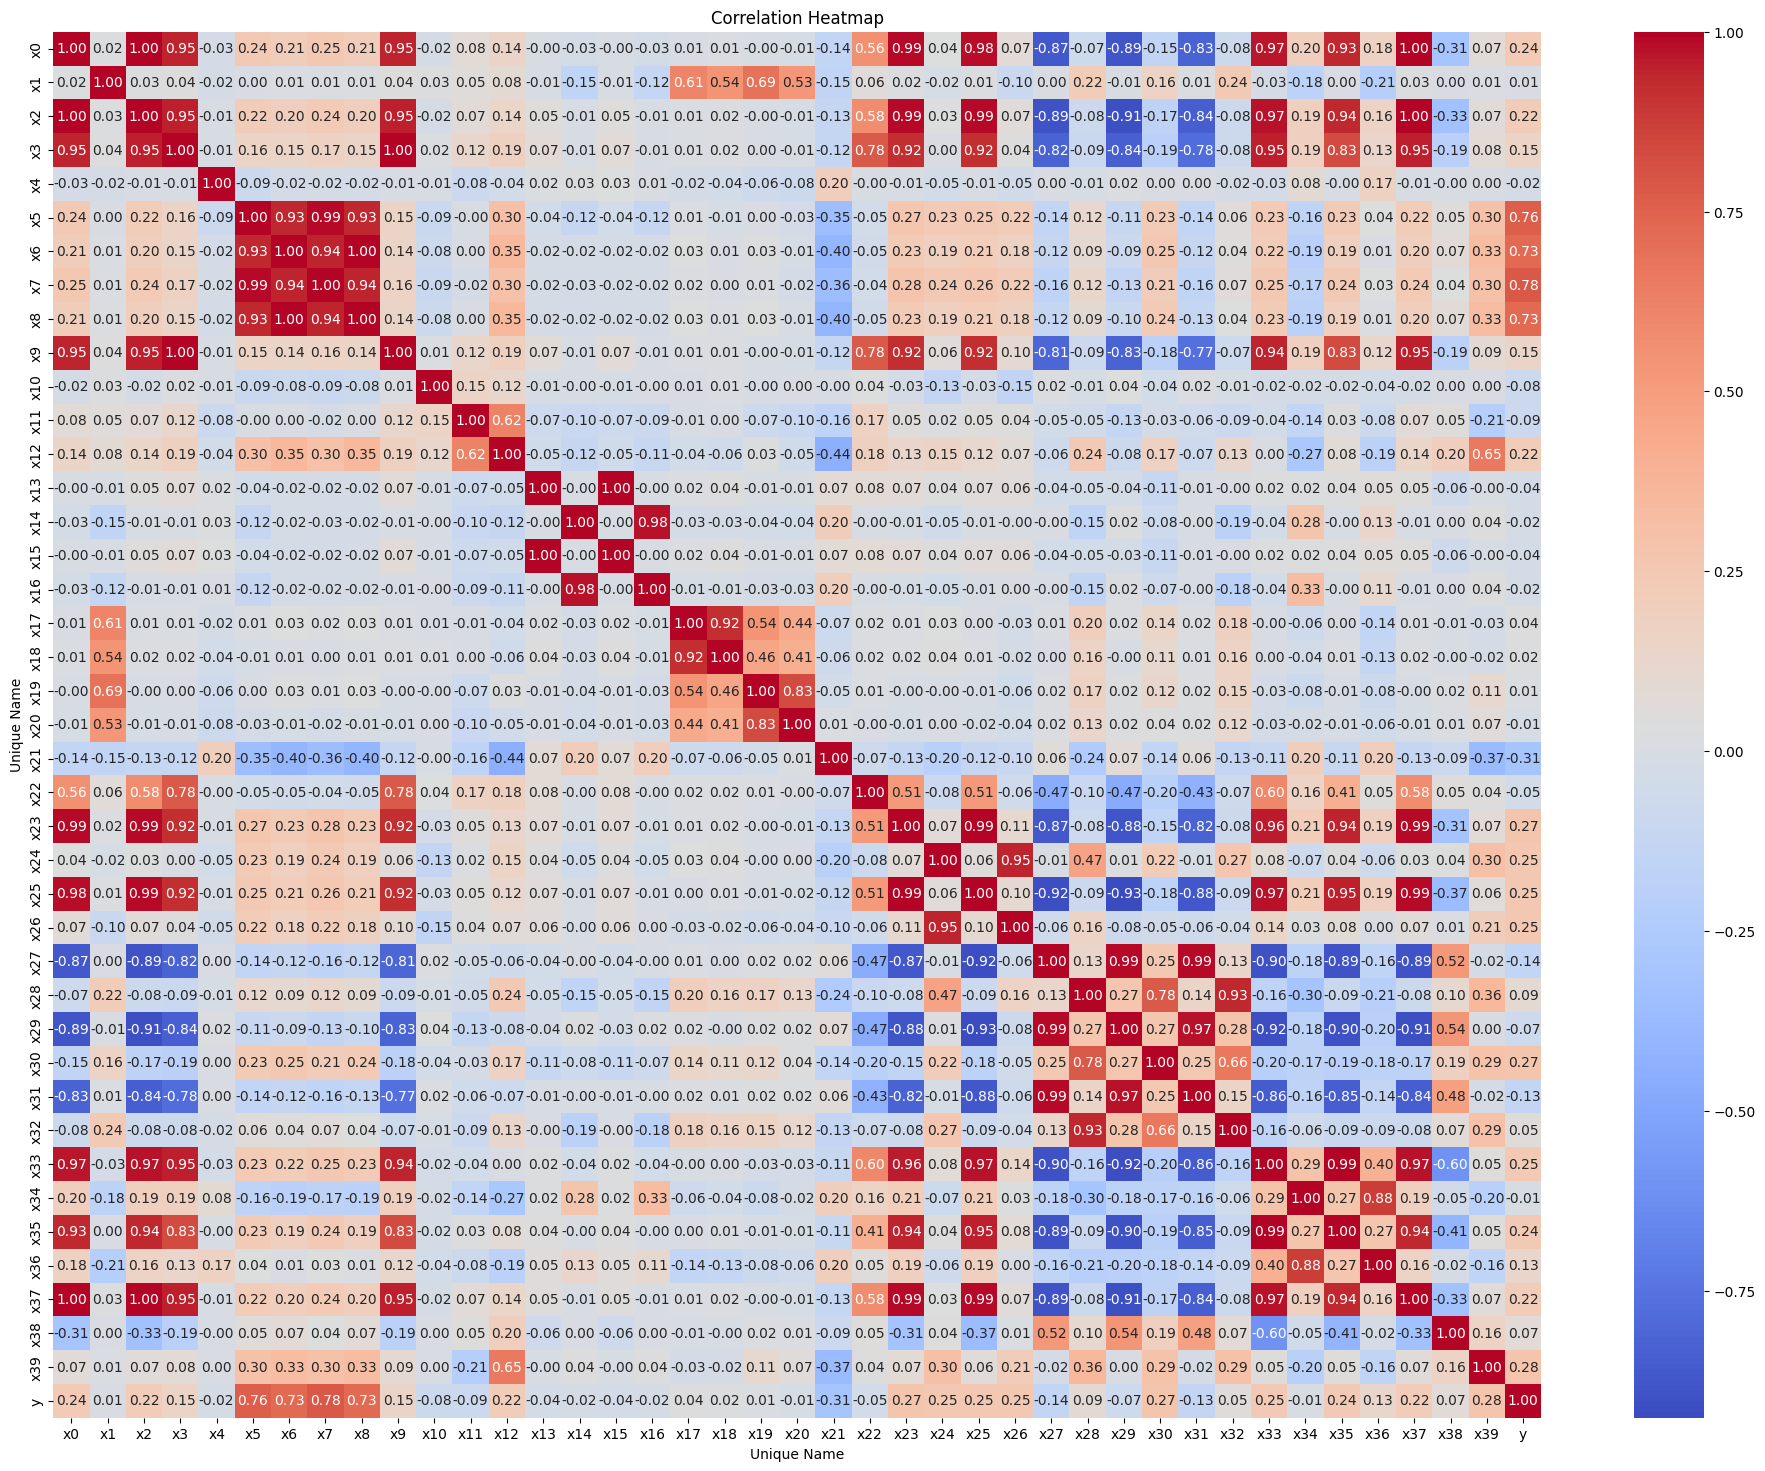

In [ ]:
correlation_matrix = df_easynames.corr()
plt.figure(figsize=(24, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
corr_matrix_pearson = full_df.corr(method='pearson', numeric_only=True)
corr_matrix_pearson["target"].sort_values(ascending=False)

Unique Name
target                                                                                                      1.000000
Gross domestic product per capita, current prices in U.S. dollars                                           0.781815
Gross domestic product per capita, constant prices in US dollars                                            0.762356
Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar    0.727017
Gross domestic product per capita, current prices in Purchasing power parity; international dollars         0.726537
Current account balance in Percent of GDP                                                                   0.281126
General government revenue in US dollars                                                                    0.273074
General government structural balance in Percent of potential GDP                                           0.271837
General government revenue in Percent of GDP        

In [ ]:
corr_matrix_spearman = full_df.corr(method='spearman', numeric_only=True)
corr_matrix_spearman["target"].sort_values(ascending=False)

Unique Name
target                                                                                                      1.000000
Gross domestic product per capita, current prices in U.S. dollars                                           0.677515
Gross domestic product per capita, constant prices in US dollars                                            0.660291
Gross domestic product per capita, constant prices in Purchasing power parity; 2017 international dollar    0.660091
Gross domestic product per capita, current prices in Purchasing power parity; international dollars         0.659471
General government revenue in US dollars                                                                    0.491808
General government total expenditure in US dollars                                                          0.475006
Gross domestic product, constant prices in US dollars                                                       0.460197
Gross domestic product corresponding to fiscal year,

From the correlation heatmap and the correlation values themselves we see several important considerations.

First, several of our non-target features are very highly correlated with each other. Some of these are not at all surprising given what they represent. For example, GDP per capita in current prices is highly correlated with GDP per capita in constant prices. This is exactly expected. However, there are features that would not intuitively be highly correlated. For example, general government revenue in US dollars is highly correlated to general government net debt in US dollars. As such there is a need to carefully consider feature selection/engineering to ensure we have the best model possible.

We also see that by far the most highly correlated features are GDP per capita in constant and current prices in US dollars as well as the GDP per capita in current and constant prices in Purchasing Power Parity in international dollars. These later features are very interesting as PPP has been proposed as a better metric with which to compare economies of different countries than pure GDP (per capita or otherwise).

## Algorithms We Intend to Apply

Our overall goal for this analysis will be to verify the IMF's classification schema of different countries economies as Advanced or Developing/Emerging. We will do this in two ways, both of which will be classification tasks. The first task will be to verify if we are able to train a machine learning model using the IMF data to predict a classifier target of advanced economy or not. For this task we use Logistic Regression, Decision Tree, and Random Forest algorithms.

** Fix below after complete

For the second verification method we will be looking at unsupervised clustering algorithms to see if we can recreate the IMFs classifications or extract new groupings that may teach us more about how to categorize countries economies. For this we intend to use K-means clustering and DBSCAN. The latter is particularly interesting as there is no need to preset a number of clusters, it will find the number of clusters on its own. We are also considering the use of PCA for visualizing the dataset and determining if simplification from the higher dimension will afford us easier separation of the targets.

# Pipeline Development

## Stratification and Split

As our data has a class imbalance ~80% to 20% in favor of developing economies we will stratify based on the target. Additionally, k-fold cross validation will be implemented within the pipeline.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_easynames.drop('y', axis=1), df_easynames['y'], test_size=0.2,
    random_state=631, stratify=df_easynames['y'])

For our cross validation we will be utilizing a 5-fold split. to be called as part of GridSearchCV()

In [ ]:
kf = KFold(n_splits=5)

## Pipeline Construction

We will try to incorporate imputation, scaling, and feature selection/engineering into the pipeline. Hyperparameter tuning will also be built in and refined as we find the best parameters.

Note different models will have different requirements for imputation and scaling.

### Imputation Strategy

We elect to use a KNN imputer for our data.

In [ ]:
#Construct Imputer
knn_imputer = KNNImputer(n_neighbors=3)

### Scalers
We will be implementing Standard and Robust Scalers.

### Transformations

We will implement a simple log transform for our logistic regression pipeline.

In [ ]:
def log_transform(x):
    return np.log(x + 1)

### Feature Selection Strategy

We will use Recursive Feature Elimination as it allows us to automatically tune it with the hyperparameters.

In [ ]:
# This will have the following form in our pipelines below.
# selector = RFE(estimator, n_features_to_select, step)

## Unsupervised Models

### PCA

Note to us: this could be dropped if time is of the essence

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
# PCA Preproccessing

imp_df = pd.DataFrame(knn_imputer.fit_transform(df_easynames.drop('y', axis=1)))
#print(imp_X_train.head())
std_scaler = StandardScaler()

df_scaled = pd.DataFrame(std_scaler.fit_transform(imp_df))

pca = PCA()

df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
df_pca.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
712,-0.338421,-2.175246,-1.458306,0.680540,-1.619399,0.544270,0.716378,0.719018,1.247230,-0.450694,...,0.051604,-0.098884,0.052359,-0.030701,0.048086,-0.048529,-0.001242,-0.000141,-6.206845e-08,2.002610e-06
651,-0.123635,-0.541739,-2.448437,-1.183821,1.927297,-0.868430,-1.160638,-1.069377,-1.013401,-1.100705,...,0.053559,-0.005299,0.012134,0.003732,-0.011963,0.013788,-0.001956,-0.000393,-4.364184e-05,8.309303e-07
295,-0.628606,1.350854,-0.040273,-0.322860,-0.372801,-0.230888,-0.041072,0.575513,0.880783,-0.302422,...,0.070297,-0.010440,-0.011014,0.007897,0.004700,0.010214,0.000073,0.000131,2.461499e-07,2.466615e-06
670,10.981520,-0.180694,-3.090273,0.274250,1.068668,-0.462777,-1.748395,0.948644,-4.751778,1.040858,...,0.229306,0.270956,-0.170356,-0.048000,0.003928,-0.007241,-0.007621,-0.000138,-3.432697e-06,8.348438e-06
375,-1.098372,4.282103,3.037548,-10.676574,-0.626210,-4.652901,4.622845,0.588266,-1.154339,1.351643,...,0.017845,-0.063722,0.001105,-0.035648,0.033333,-0.016542,-0.002574,0.000247,1.402034e-05,1.450230e-06


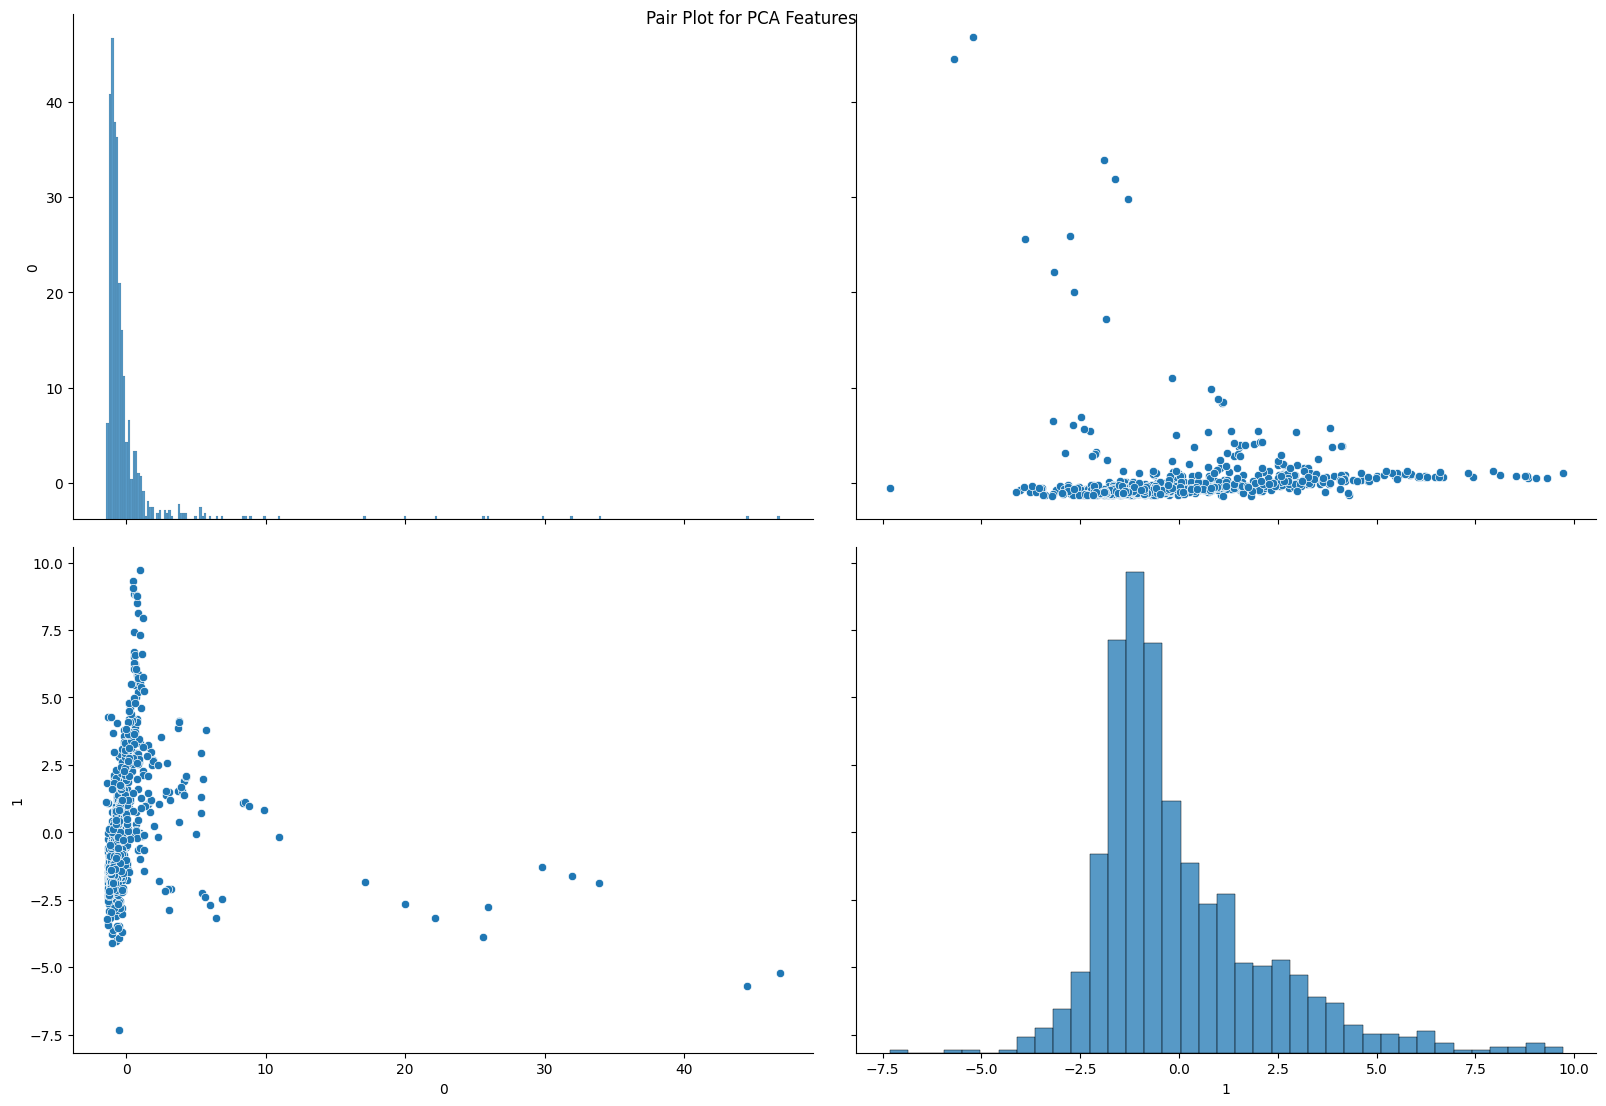

In [ ]:
pair_plot = sns.pairplot(df_pca.iloc[:,:2], diag_kind='hist')
pair_plot.fig.set_size_inches(18, 12)
pair_plot.fig.suptitle('Pair Plot for PCA Features')
plt.show()

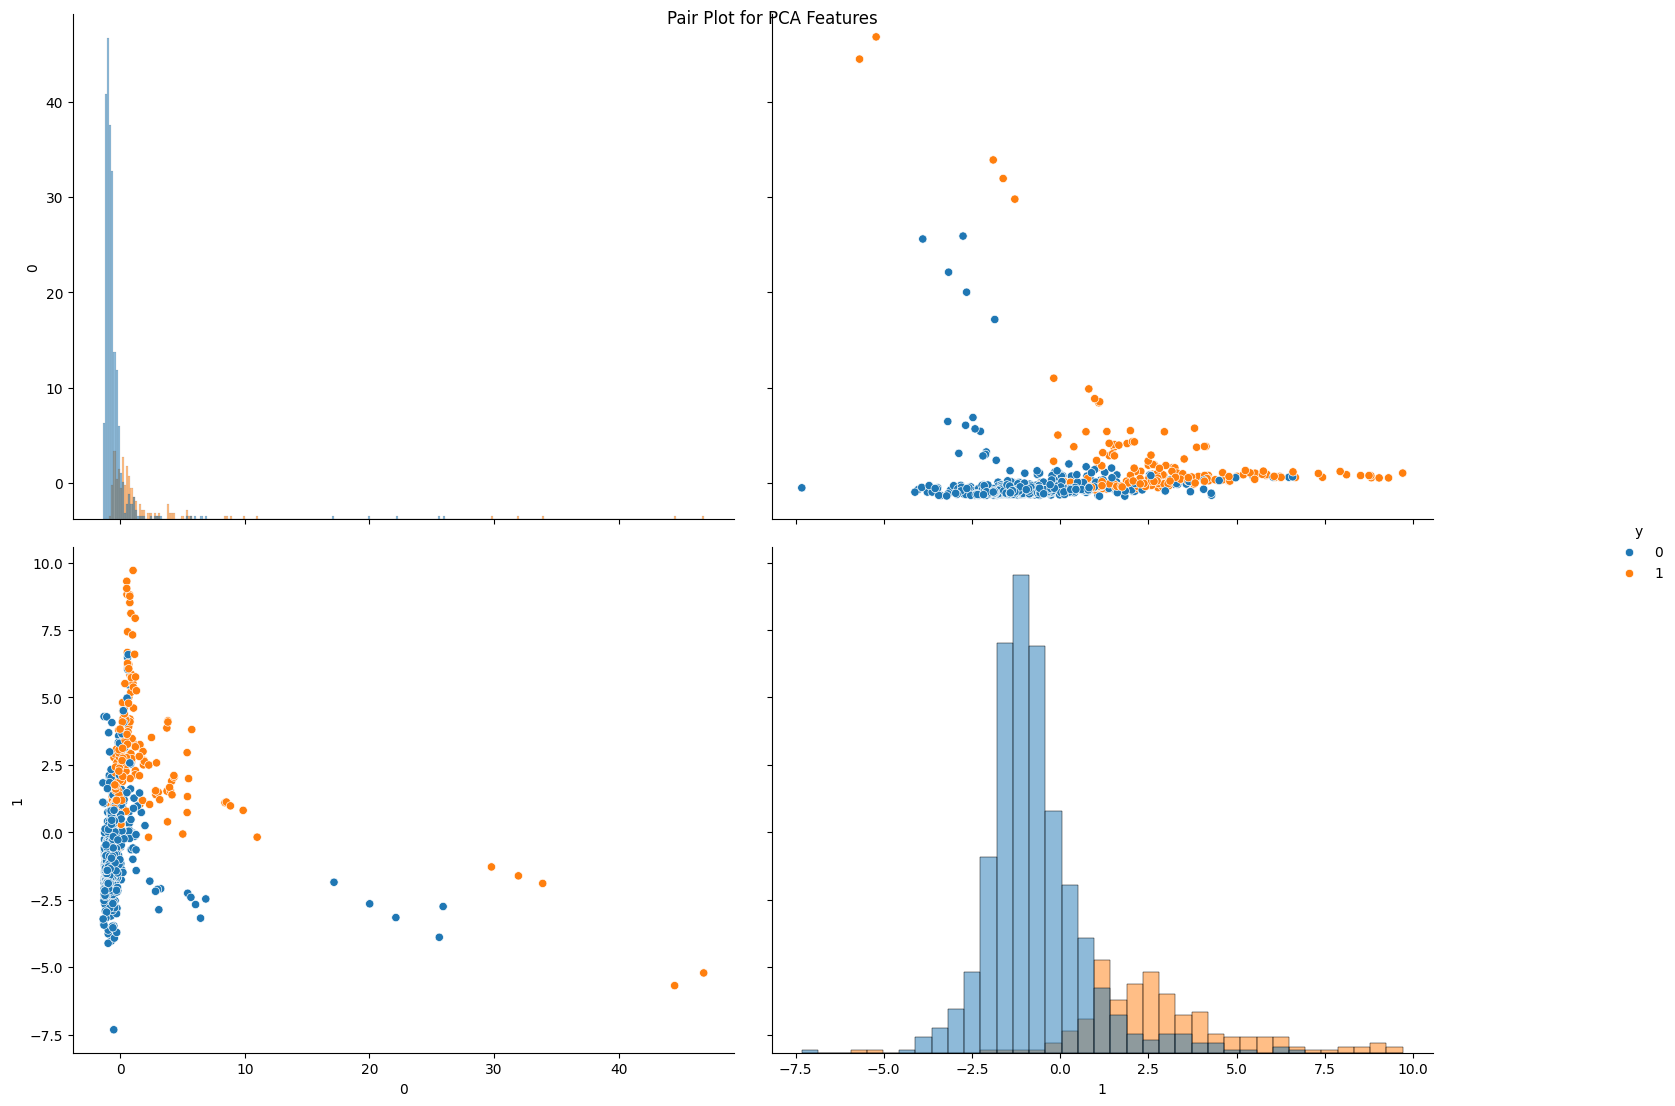

In [ ]:
df_pca1 = df_pca.iloc[:,:2].copy()
df_pca1['y'] = df_easynames['y'].values
pair_plot = sns.pairplot(df_pca1, hue='y', diag_kind='hist')
pair_plot.fig.set_size_inches(18, 12)
pair_plot.fig.suptitle('Pair Plot for PCA Features')
plt.show()

### K-Means Clustering

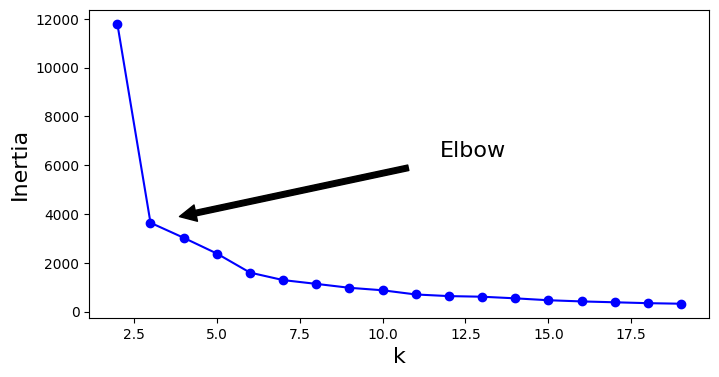

In [ ]:
from sklearn.cluster import KMeans
df_clus = df_pca.iloc[:,:2].values
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init="auto").fit(df_clus) for k in range(2, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

# Elbow plot to see optimal no of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("k", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.annotate('Elbow',
             xy=(3, inertias[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

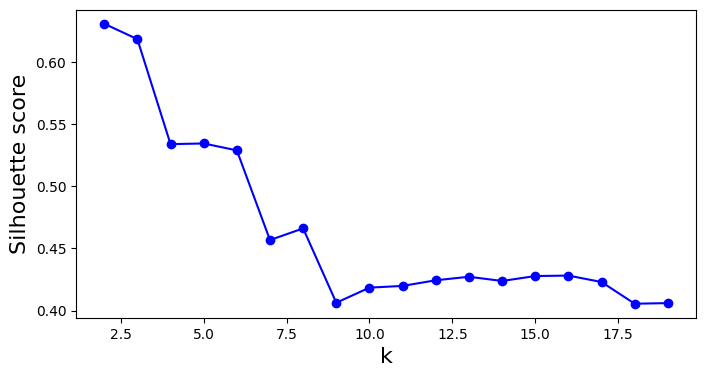

In [ ]:
# Silhouette_score to see optimal no of clusters
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(df_clus, model.labels_) for model in kmeans_per_k]
plt.figure(figsize=(8, 4))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=16)
plt.ylabel("Silhouette score", fontsize=16)
plt.show()

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("PCA1", fontsize=16)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("PCA2", fontsize=16)
    else:
        plt.tick_params(labelleft=False)

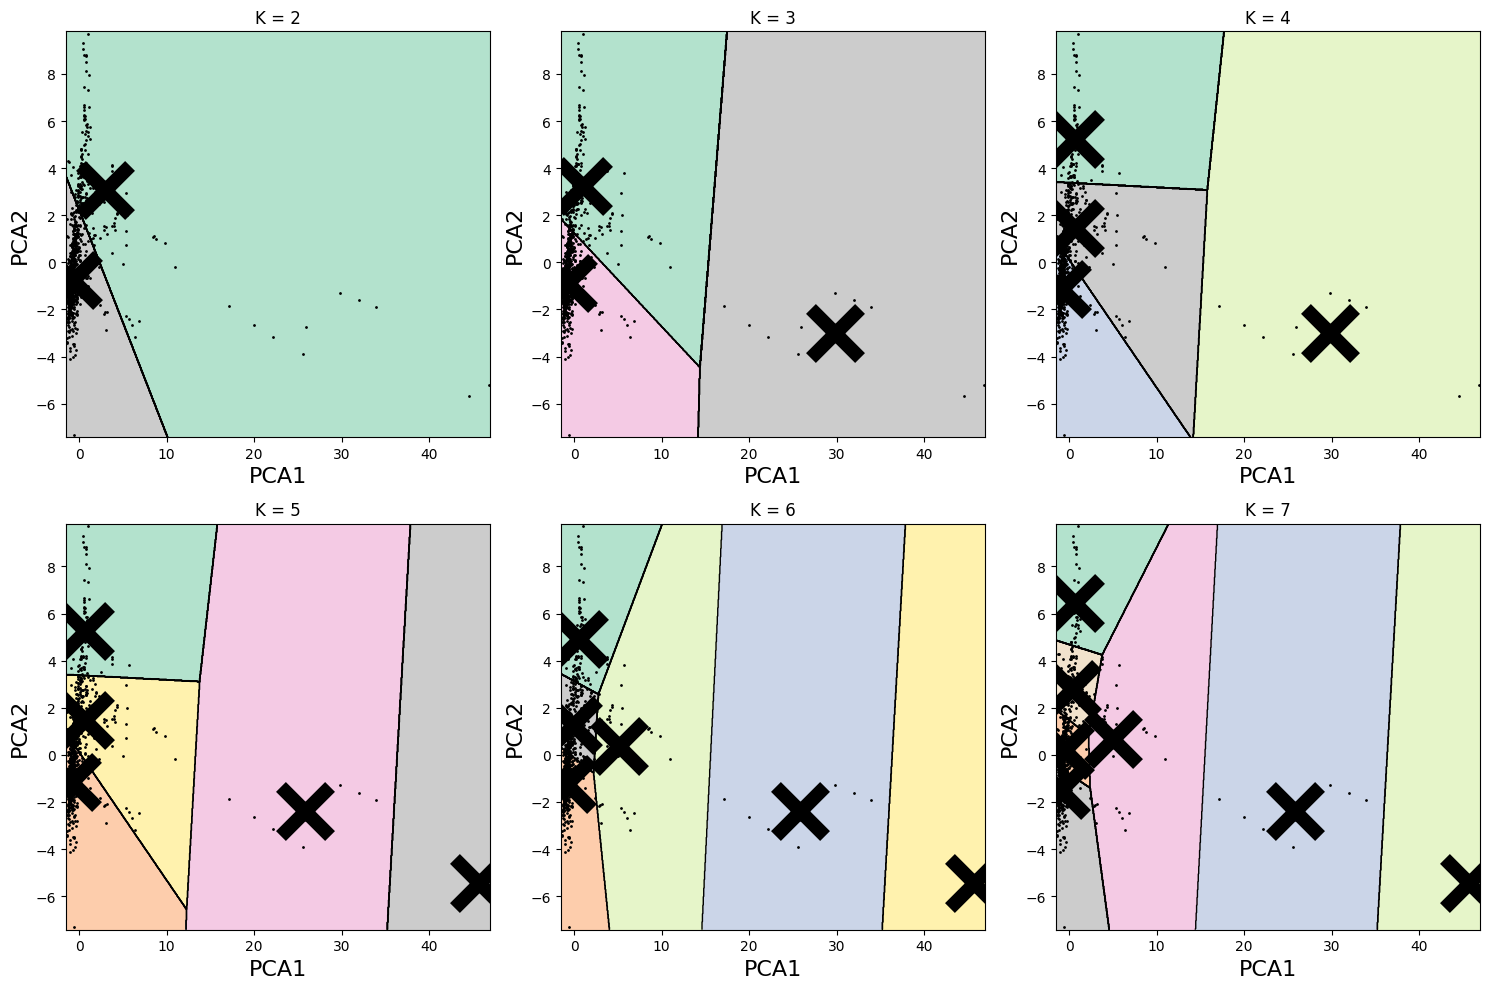

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    plt.sca(ax)
    plot_decision_boundaries(kmeans_per_k[i], df_clus)
    ax.set_title(f'K = {i + 2}')

plt.tight_layout()
plt.show()

In [ ]:
for i in range(6):
    print(f'Score for k = {i + 2}: {kmeans_per_k[i].score(df_clus)}')

Score for k = 2: -11803.636634895442
Score for k = 3: -3640.8314135269616
Score for k = 4: -3025.335125836778
Score for k = 5: -2379.3493944895936
Score for k = 6: -1597.4304894036186
Score for k = 7: -1289.7369563876239


Based on the scores from the elbow method and silhouette score indicate that clustering into 3 clusters would be a better option. Though these values are still poor and may perform better if all PCA components are included. We have included the 1st 2 components as it explains just over 40% of the variance and is easy to visualize.

### DBSCAN

This can be dropped if time if of the essence

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(df_clus)

dbscan2 = DBSCAN(eps=0.2, min_samples=5)
dbscan2.fit(df_clus)

dbscan3 = DBSCAN(eps=0.3, min_samples=5)
dbscan3.fit(df_clus)

dbscan4 = DBSCAN(eps=0.4, min_samples=5)
dbscan4.fit(df_clus)

dbscan5 = DBSCAN(eps=0.5, min_samples=5)
dbscan5.fit(df_clus)

dbscan6 = DBSCAN(eps=0.6, min_samples=5)
dbscan6.fit(df_clus)

dbscan7 = DBSCAN(eps=0.7, min_samples=5)
dbscan7.fit(df_clus)

dbscan8 = DBSCAN(eps=0.8, min_samples=5)
dbscan8.fit(df_clus)

DBSCAN(eps=0.8)

In [ ]:
def plot_dbscan(dbscan, X, size = [100, 40]):
    cores = dbscan.components_
    anomalies = X[dbscan.labels_ == -1]
    bound_index = list(set(np.where(dbscan.labels_ != -1)[0]).symmetric_difference(dbscan.core_sample_indices_))
    boundaries = X[bound_index]

    plt.scatter(cores[:, 0], cores[:, 1], marker='^', s=size[0],# edgecolors='k',
                c=dbscan.labels_[dbscan.core_sample_indices_], cmap=plt.cm.Paired)

    plt.scatter(boundaries[:, 0], boundaries[:, 1], marker='o', s=size[1], edgecolors='k',
                c=dbscan.labels_[bound_index], cmap=plt.cm.Paired)

    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=size[0])
    plt.xlabel("PCA1", fontsize=16)
    plt.ylabel("PCA2", fontsize=16)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=16)

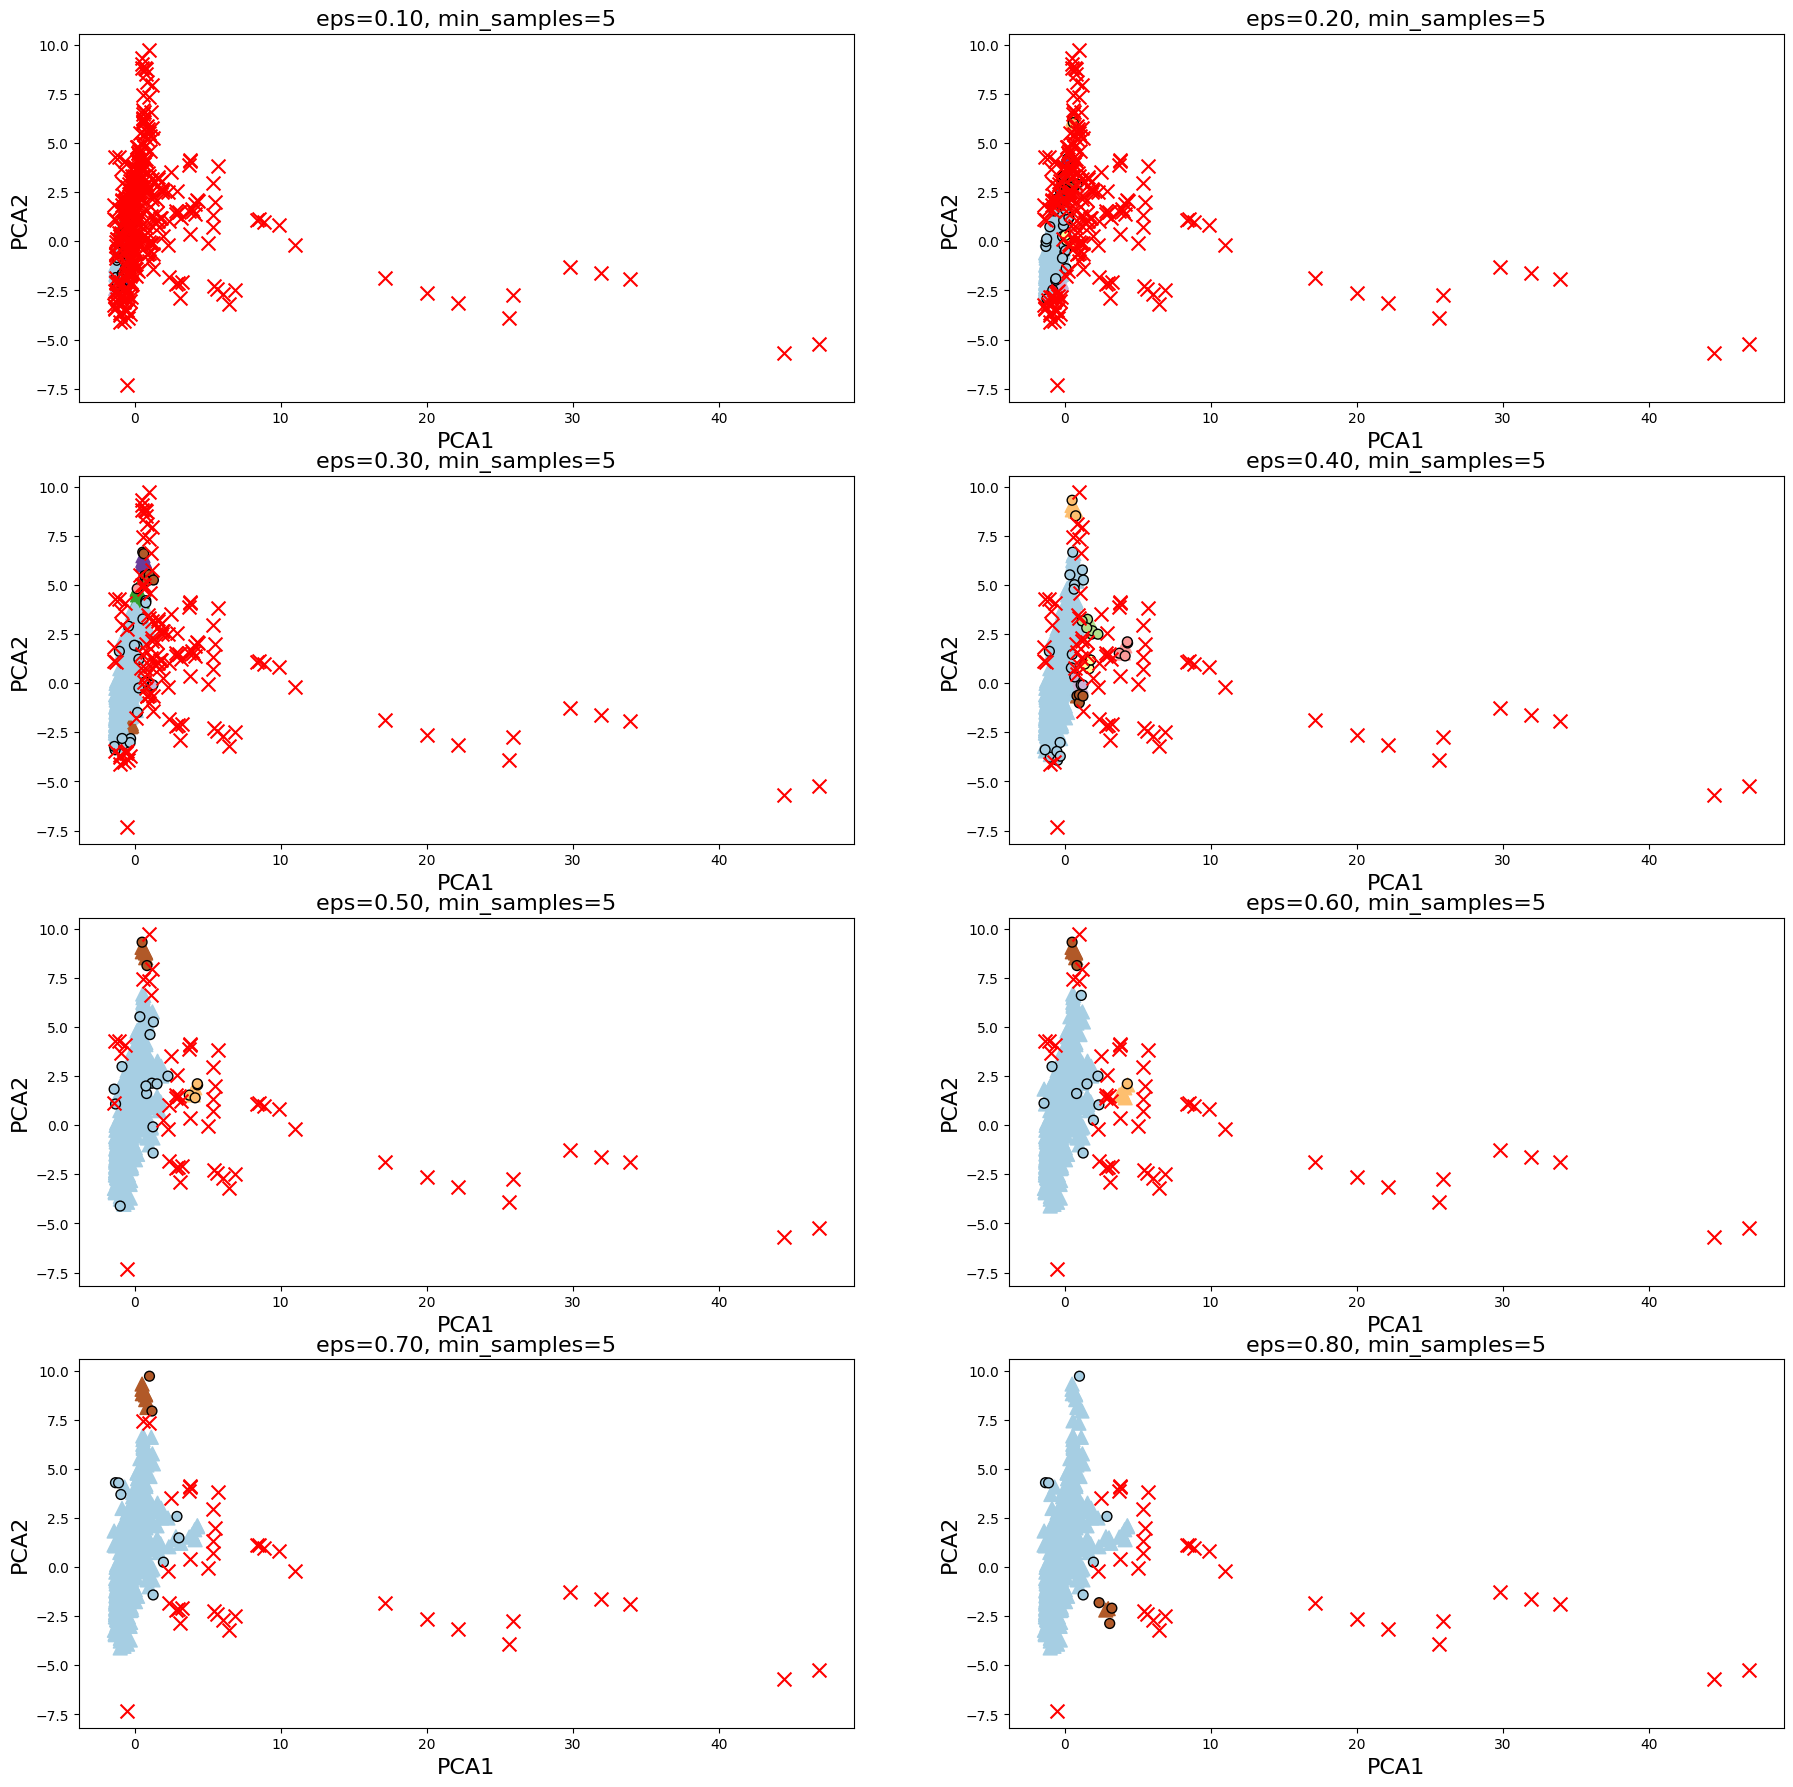

In [ ]:
plt.figure(figsize=(22, 22))

plt.subplot(421)
plot_dbscan(dbscan, df_clus, [100, 30])

plt.subplot(422)
plot_dbscan(dbscan2, df_clus, [100, 50])

plt.subplot(423)
plot_dbscan(dbscan3, df_clus, [100, 50])

plt.subplot(424)
plot_dbscan(dbscan4, df_clus, [100, 50])

plt.subplot(425)
plot_dbscan(dbscan5, df_clus, [100, 50])

plt.subplot(426)
plot_dbscan(dbscan6, df_clus, [100, 50])

plt.subplot(427)
plot_dbscan(dbscan7, df_clus, [100, 50])

plt.subplot(428)
plot_dbscan(dbscan8, df_clus, [100, 50])

plt.show()

### Agglomerative Clustering

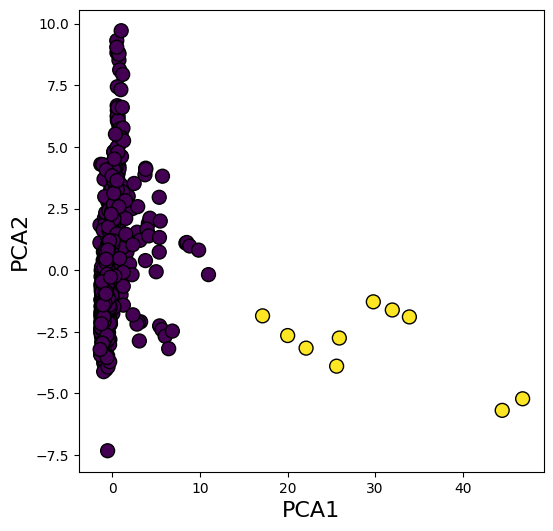

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(df_clus)

plt.figure(figsize=(6,6))
plt.scatter(df_clus[:, 0], df_clus[:, 1], c = assignment, s = 100, edgecolors='k')
plt.xlabel("PCA1", fontsize = 16)
plt.ylabel("PCA2", fontsize = 16)
plt.show()

ward : [965  10]
average : [965  10]
complete : [965  10]
single : [973   2]


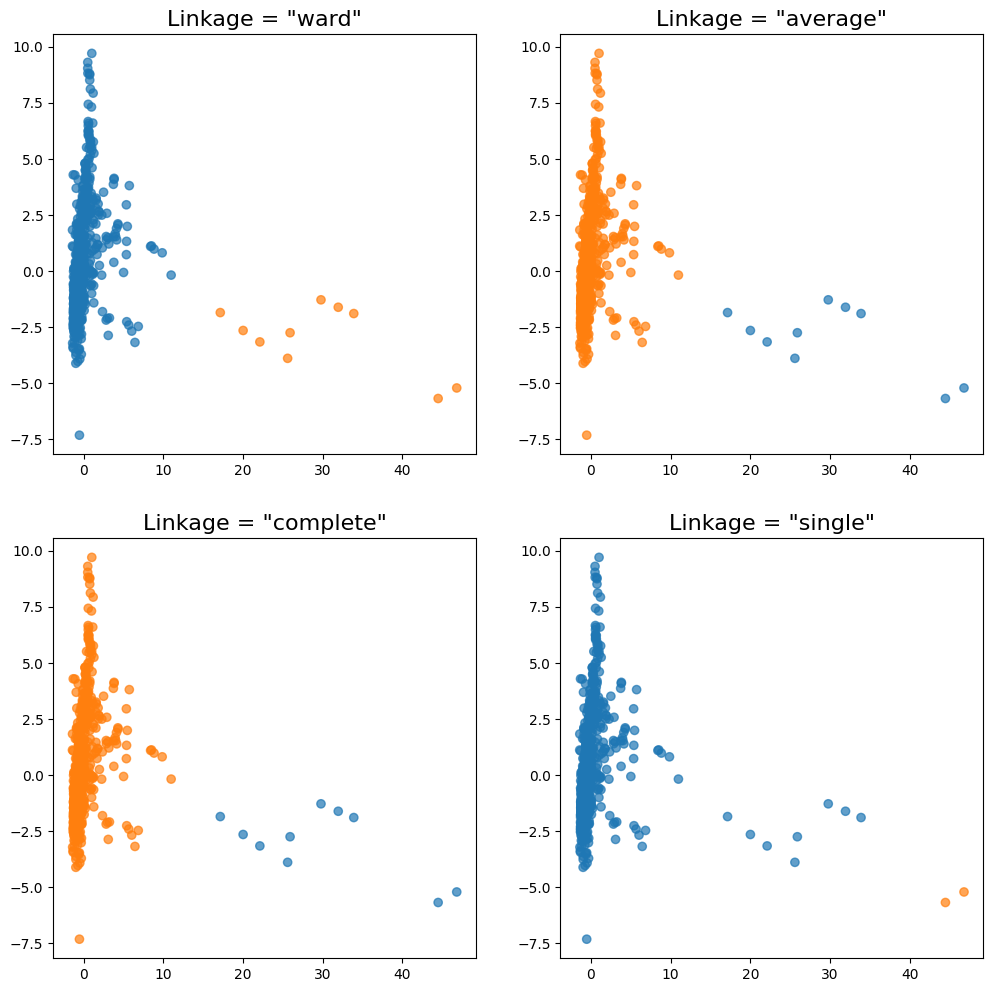

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
for i, linkage in enumerate(["ward", "average", "complete", "single"]):
    agg = AgglomerativeClustering(n_clusters=2, linkage=linkage)
    agg.fit(df_clus)
    plt.sca(axes[i // 2, i % 2])
    plt.scatter(df_clus[:, 0], df_clus[:, 1], c=plt.cm.tab10(agg.labels_), alpha=.7)
    plt.title('Linkage = "{}"'.format(linkage), fontsize = 16)
    print('{} : {}'.format(linkage, np.sort(np.bincount(agg.labels_))[::-1]))

### Gaussian Mixtures

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gm.fit(df_clus)

GaussianMixture(n_components=2, n_init=10, random_state=42)

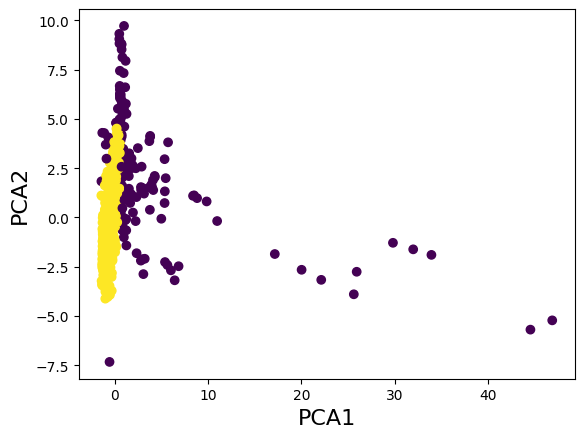

In [ ]:
y_pred = gm.predict(df_clus)
plt.scatter(df_clus[:,0], df_clus[:,1], c=y_pred)
plt.xlabel("PCA1", fontsize = 16)
plt.ylabel("PCA2", fontsize = 16)
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("PCA1", fontsize=16)
    plt.ylabel("PCA2", fontsize=16)

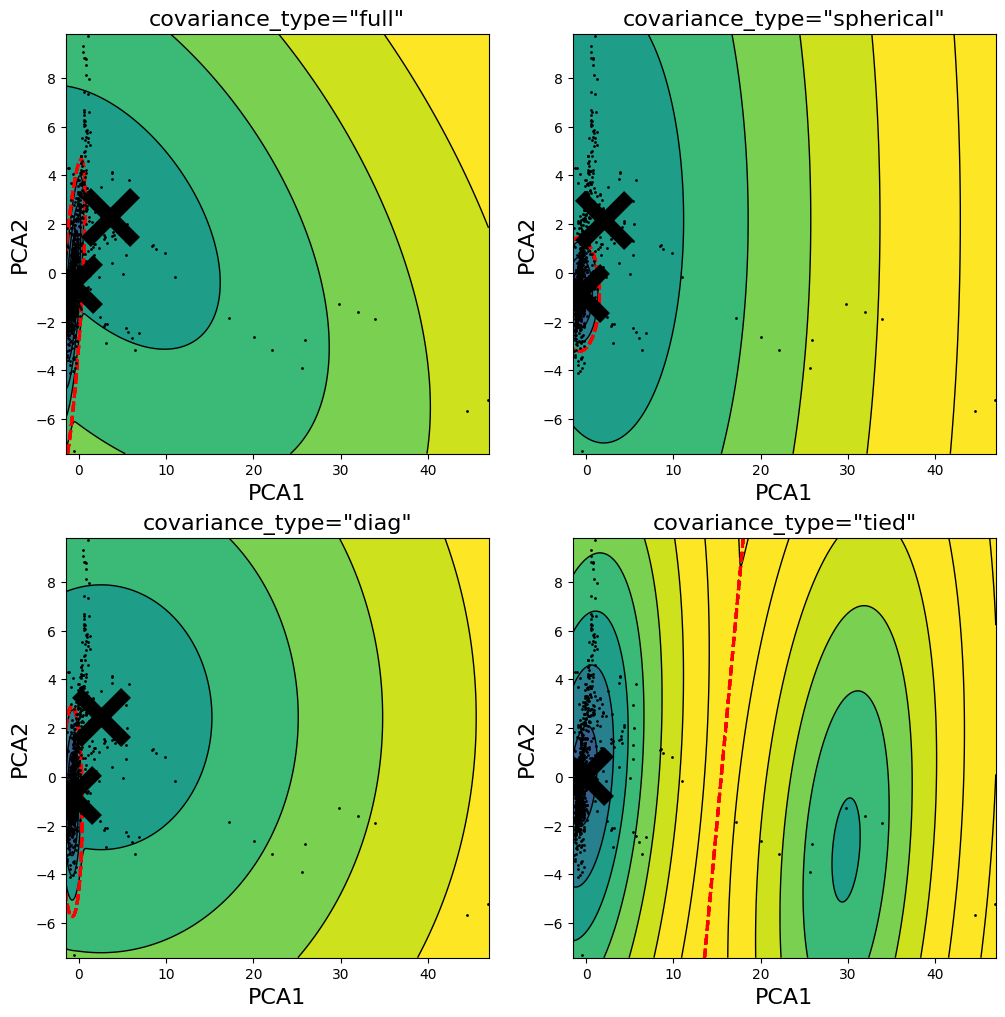

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
for i, cov in enumerate(["full", "spherical", "diag", "tied"]):
    gm_type = GaussianMixture(n_components=2, n_init=10, covariance_type=cov, random_state=42)
    gm_type.fit(df_clus)
    plt.sca(axes[i // 2, i % 2])
    plot_gaussian_mixture(gm_type, df_clus)
    plt.title('covariance_type="{}"'.format(gm_type.covariance_type), fontsize=16)

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(df_clus) for k in range(2, 11)]

bics = [model.bic(df_clus) for model in gms_per_k]
aics = [model.aic(df_clus) for model in gms_per_k]

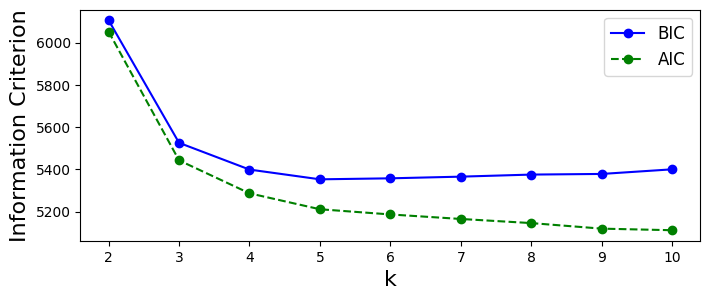

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), bics, "bo-", label="BIC")
plt.plot(range(2, 11), aics, "go--", label="AIC")
plt.xlabel("k", fontsize=16)
plt.ylabel("Information Criterion", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(df_clus).bic(df_clus)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [ ]:
print(f"Best k: {best_k}\nBest Covariance Type: {best_covariance_type}")

Best k: 5
Best Covariance Type: full


### Model Evaluation

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
# K means
print('K means (k=2)')
print(f"normalized_mutual_info_score: {normalized_mutual_info_score(labels_true = df_pca1['y'],labels_pred = kmeans_per_k[0].labels_, average_method='arithmetic')}")
print(f"adjusted_rand_score: {adjusted_rand_score(labels_true = df_pca1['y'], labels_pred = kmeans_per_k[0].labels_)}")

# DBSCAN
print('\nDBSCAN')
print(f"normalized_mutual_info_score: {normalized_mutual_info_score(labels_true = df_pca1['y'],labels_pred = dbscan8.labels_, average_method='arithmetic')}")
print(f"adjusted_rand_score: {adjusted_rand_score(labels_true = df_pca1['y'], labels_pred = dbscan8.labels_)}")

# Agglomerative Clustering
print('\nAgglomerative Clustering')
print(f"normalized_mutual_info_score: {normalized_mutual_info_score(labels_true = df_pca1['y'],labels_pred = assignment, average_method='arithmetic')}")
print(f"adjusted_rand_score: {adjusted_rand_score(labels_true = df_pca1['y'], labels_pred = assignment)}")

# Gaussian Mixtures
print('\nGaussian Mixtures')
print(f"normalized_mutual_info_score: {normalized_mutual_info_score(labels_true = df_pca1['y'],labels_pred = y_pred, average_method='arithmetic')}")
print(f"adjusted_rand_score: {adjusted_rand_score(labels_true = df_pca1['y'], labels_pred = y_pred)}")

K means (k=2)
normalized_mutual_info_score: 0.3955383189940556
adjusted_rand_score: 0.5777688363613122

DBSCAN
normalized_mutual_info_score: 0.05236904420828541
adjusted_rand_score: 0.09107931503444604

Agglomerative Clustering
normalized_mutual_info_score: 0.00743805187377737
adjusted_rand_score: 0.020076125670635537

Gaussian Mixtures
normalized_mutual_info_score: 0.17598207568900548
adjusted_rand_score: 0.3344522403257472


The clustering performance varies significantly across different algorithms. K-Means achieved the highest scores,indicating moderate alignment with the ground truth labels.
Gaussian Mixtures performed moderately well.
DBSCAN and Agglomerative Clustering showed poor performance, with particularly low scores for Agglomerative Clustering suggesting its clusters are almost random compared to the true labels.
Overall, K-Means proved to be the most effective clustering method for this dataset.


## Supervised Classification Models
Below we look at three different models in for supervised classification. Our goal is to see if we are capable of classifying each data point as an advanced or developing economy.

We look at Logistic Regression, Decision Tree, and Random Forest algorithms

### Logistic Regression

In [ ]:
# Logistic Regression Preprocessing Pipeline

# No transform pipeline with StandardScaler()
num1_pipeline = Pipeline([
        ('imputer', knn_imputer),
        ('scaler', StandardScaler())
    ])

# No transformation pipeline with RobustScaler() for values with large outliers
num2_pipeline = Pipeline([
        ('imputer', knn_imputer),
        ('scaler', RobustScaler())
    ])

# Log pipeline with StandardScaler()
log1_pipeline = Pipeline([
        ('imputer', knn_imputer),
        ('transform', FunctionTransformer(log_transform, feature_names_out='one-to-one')),
        ('scaler', StandardScaler())
    ])

# Log pipeline with RobustScaler for values with large outliers
log2_pipeline = Pipeline([
        ('imputer', knn_imputer),
        ('transform', FunctionTransformer(log_transform, feature_names_out='one-to-one')),
        ('scaler', RobustScaler())
    ])

# Define the full pipeline using ColumnTransformer
num1_attribs = ['x1', 'x11', 'x12', 'x17', 'x18', 'x19', 'x20',  'x27',
                'x28', 'x30',  'x32', 'x34', 'x39']
num2_attribs  = ['x14', 'x16', 'x24',  'x29', 'x31', 'x33', 'x36', 'x38']
log1_attribs = ['x0', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
                'x21', 'x22', 'x23', 'x25', 'x26', 'x35', 'x37']
log2_attribs =['x4', 'x13', 'x15']


# Full pipeline
preprocessing_pipeline = ColumnTransformer([
        ("num1", num1_pipeline, num1_attribs),
        ("num2", num2_pipeline, num2_attribs),
        ("log1", log1_pipeline, log1_attribs),
        ("log2", log2_pipeline, log2_attribs)
    ])


In [ ]:
sel_model = LogisticRegression(solver='liblinear', max_iter=1000)
selector = RFE(sel_model)

model = LogisticRegression(solver='liblinear', max_iter=1000)

pipeline = Pipeline([
    ('pre', preprocessing_pipeline),
    ('rfe', selector),
    ('model', model)
])

param_grid = {'rfe__n_features_to_select': [0.1, 0.25, 0.5, 0.75, 1.0], 'rfe__step': [1, 0.1, 0.5],
              'model__penalty': ['l1', 'l2'], 'model__C': [.01, .1, 1, 10, 100]} # continue with feature selection

log_grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1')

log_grid_search.fit(X_train, y_train)

print(f'Best parameters: {log_grid_search.best_params_}')
print(f'Best score: {log_grid_search.best_score_}') # f1 score
best_log_model = log_grid_search.best_estimator_

Best parameters: {'model__C': 100, 'model__penalty': 'l1', 'rfe__n_features_to_select': 1.0, 'rfe__step': 0.1}
Best score: 0.8919379584273655


In [ ]:
y_train_pred = best_log_model.predict(X_train)

f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)

print(f'F1 Score (Train): {f1}')
print(f'Precision (Train): {precision}')
print(f'Recall (Train): {recall}')

F1 Score (Train): 0.9361702127659574
Precision (Train): 0.9333333333333333
Recall (Train): 0.9390243902439024


In [ ]:
selected_features = X_train.columns[best_log_model.named_steps['rfe'].get_support()]
print(f'Selected Features: {selected_features}')

Selected Features: Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39'],
      dtype='object', name='Unique Name')


In [ ]:
best_log_model = log_grid_search.best_estimator_
best_log_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['x1', 'x11', 'x12', 'x17',
                                                   'x18', 'x19', 'x20', 'x27',
                                                   'x28', 'x30', 'x32', 'x34',
                                                   'x39']),
                                                 ('num2',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['x14', 'x16', 'x24', 'x29',
                                                   'x31', 'x...
                                                                  ('transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_transform at 0x7cb21eecb880>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['x4', 'x13', 'x15'])])),
                ('rfe',
                 RFE(estimator=LogisticRegression(max_iter=1000,
                                                  solver='liblinear'),
                     n_features_to_select=1.0, step=0.1)),
                ('model',
                 LogisticRegression(C=100, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
y_test_pred = best_log_model.predict(X_test)

f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'F1 Score (Test): {f1}')
print(f'Precision (Test): {precision}')
print(f'Recall (Test): {recall}')

F1 Score (Test): 0.8311688311688312
Precision (Test): 0.8888888888888888
Recall (Test): 0.7804878048780488


In [ ]:
# Saving to reuse later without rerunning the model
filename = 'log_model.sav'
joblib.dump(best_log_model, filename)

['log_model.sav']

Below we test that reloading the model both works and provides the same result.

In [ ]:
# Reload the model
loaded_model = joblib.load('log_model.sav')

# Showing this works
y_test_pred = loaded_model.predict(X_test)

f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'F1 Score (Test): {f1}')
print(f'Precision (Test): {precision}')
print(f'Recall (Test): {recall}')

F1 Score (Test): 0.8311688311688312
Precision (Test): 0.8888888888888888
Recall (Test): 0.7804878048780488


### Decision Tree

The preprocessing for Decision Trees is significantly simpler as there is no need for scaling or transformations.


In [ ]:
# Decision Tree Preproccessing

# No transform pipeline with StandardScaler()
num_pipeline = Pipeline([
        ('imputer', knn_imputer),
    ])

# Define the full pipeline using ColumnTransformer
num_attribs = X_train.columns # Fix up the large outlier ones that were getting shifted by log transform


# Full pipeline
preprocessing_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

In [ ]:
# Implement Decision Tree pipeline
model = DecisionTreeClassifier(random_state=631)
selector = RFE(model)


pipeline = Pipeline([
    ('pre', preprocessing_pipeline), # This preprocessing pipeline will be different
    ('rfe', selector),
    ('model', model)
])

param_grid = {'rfe__n_features_to_select': [0.1, 0.25, 0.5, 0.75, 1.0],
            'rfe__step': [1, 0.1, 0.5],
            'model__max_depth': [2, 5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 5, 10, 20],
             }


tree_grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1', error_score='raise')

tree_grid_search.fit(X_train, y_train)

# We look at RMSE for the traindata
print(f'Best parameters: {tree_grid_search.best_params_}')
print(f'Best score: {tree_grid_search.best_score_}') # F1 score
best_tree_model = tree_grid_search.best_estimator_
best_tree_model

Best parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'rfe__n_features_to_select': 0.1, 'rfe__step': 0.5}
Best score: 0.9291287002284443


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39'],
      dtype='object', name='Unique Name'))])),
                ('rfe',
                 RFE(estimator=DecisionTreeClassifier(random_state=631),
                     n_features_to_select=0.1, step=0.5)),
                ('model',
                 DecisionTreeClassifier(max_depth=10, random_state=631))])

In [ ]:
selected_features = X_train.columns[best_tree_model.named_steps['rfe'].get_support()]
print(f'Selected Features: {selected_features}')

Selected Features: Index(['x7', 'x12', 'x15', 'x24'], dtype='object', name='Unique Name')


In [ ]:
y_train_pred = best_tree_model.predict(X_train)

f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)

print(f'F1 Score (Train): {f1}')
print(f'Precision (Train): {precision}')
print(f'Recall (Train): {recall}')

F1 Score (Train): 1.0
Precision (Train): 1.0
Recall (Train): 1.0


In [ ]:
y_test_pred = best_tree_model.predict(X_test)

f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'F1 Score (Test): {f1}')
print(f'Precision (Test): {precision}')
print(f'Recall (Test): {recall}')

F1 Score (Test): 0.9487179487179488
Precision (Test): 1.0
Recall (Test): 0.9024390243902439


In [ ]:
# Saving to reuse later without rerunning the model
filename = 'tree_model.sav'
joblib.dump(best_tree_model, filename)

['tree_model.sav']

In [ ]:
# Reload the model
loaded_model = joblib.load('tree_model.sav')

# Showing this works
y_test_pred = loaded_model.predict(X_test)

f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'F1 Score (Test): {f1}')
print(f'Precision (Test): {precision}')
print(f'Recall (Test): {recall}')

F1 Score (Test): 0.9487179487179488
Precision (Test): 1.0
Recall (Test): 0.9024390243902439


### Random Forest

Similarly to Decision Trees, Random Forest has no need for scaling or transformations.


In [ ]:
# Random Forest Preprocessing

num_pipeline = Pipeline([
        ('imputer', knn_imputer),
    ])

# Define the full pipeline using ColumnTransformer
num_attribs = X_train.columns


# Full pipeline
preprocessing_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

In [ ]:
# Implement Random Forest pipeline
sel_model = DecisionTreeClassifier(random_state=631)
selector = RFE(sel_model)

model = RandomForestClassifier(random_state=631)

pipeline = Pipeline([
    ('pre', preprocessing_pipeline), # This preprocessing pipeline will be different
    ('rfe', selector),
    ('model', model)
])

param_grid = {'rfe__n_features_to_select': [0.1, 0.25, 0.5, 0.75, 1.0],
            'rfe__step': [1, 0.1, 0.5],
            'model__max_depth': [2, 5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 5, 10, 20],
             }


forest_grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1', error_score='raise')

forest_grid_search.fit(X_train, y_train)

# We look at RMSE for the traindata
print(f'Best parameters: {forest_grid_search.best_params_}')
print(f'Best score: {forest_grid_search.best_score_}') # F1 score
best_forest_model = forest_grid_search.best_estimator_
best_forest_model

Best parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'rfe__n_features_to_select': 0.75, 'rfe__step': 1}
Best score: 0.9796757329098009


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39'],
      dtype='object', name='Unique Name'))])),
                ('rfe',
                 RFE(estimator=DecisionTreeClassifier(random_state=631),
                     n_features_to_select=0.75)),
                ('model',
                 RandomForestClassifier(max_depth=10, random_state=631))])

In [ ]:
selected_features = X_train.columns[best_forest_model.named_steps['rfe'].get_support()]
print(f'Selected Features: {selected_features}')

Selected Features: Index(['x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16',
       'x17', 'x18', 'x19', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27',
       'x28', 'x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37'],
      dtype='object', name='Unique Name')


In [ ]:
y_train_pred = best_forest_model.predict(X_train)

f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)

print(f'F1 Score (Train): {f1}')
print(f'Precision (Train): {precision}')
print(f'Recall (Train): {recall}')

F1 Score (Train): 1.0
Precision (Train): 1.0
Recall (Train): 1.0


In [ ]:
y_test_pred = best_forest_model.predict(X_test)

f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'F1 Score (Test): {f1}')
print(f'Precision (Test): {precision}')
print(f'Recall (Test): {recall}')

F1 Score (Test): 0.975609756097561
Precision (Test): 0.975609756097561
Recall (Test): 0.975609756097561


In [ ]:
# Saving to reuse later without rerunning the model
filename = 'forest_model.sav'
joblib.dump(best_forest_model, filename)

['forest_model.sav']

# Comparing Models

## Scores

In [ ]:
# Reload the model
loaded_log_model = joblib.load('log_model.sav')
loaded_dt_model = joblib.load('tree_model.sav')
loaded_rf_model = joblib.load('forest_model.sav')

# Creating predictions and scoring from the reloaded model
y_test_pred_log = loaded_log_model.predict(X_test)

f1_log = f1_score(y_test, y_test_pred_log)
precision_log = precision_score(y_test, y_test_pred_log)
recall_log = recall_score(y_test, y_test_pred_log)

y_test_pred_dt = loaded_dt_model.predict(X_test)

f1_dt = f1_score(y_test, y_test_pred_dt)
precision_dt = precision_score(y_test, y_test_pred_dt)
recall_dt = recall_score(y_test, y_test_pred_dt)

y_test_pred_rf = loaded_rf_model.predict(X_test)

f1_rf = f1_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf)
recall_rf = recall_score(y_test, y_test_pred_rf)

print('Test Scores for Logistic Regression Model:')
print(f'F1 Score (Test): {f1_log}')
print(f'Precision (Test): {precision_log}')
print(f'Recall (Test): {recall_log}')

print('\nTest Scores for Decision Tree Model:')
print(f'F1 Score (Test): {f1_dt}')
print(f'Precision (Test): {precision_dt}')
print(f'Recall (Test): {recall_dt}')

print('\nTest Scores for Random Forest Model:')
print(f'F1 Score (Test): {f1_rf}')
print(f'Precision (Test): {precision_rf}')
print(f'Recall (Test): {recall_rf}')

Test Scores for Logistic Regression Model:
F1 Score (Test): 0.8311688311688312
Precision (Test): 0.8888888888888888
Recall (Test): 0.7804878048780488

Test Scores for Decision Tree Model:
F1 Score (Test): 0.9487179487179488
Precision (Test): 1.0
Recall (Test): 0.9024390243902439

Test Scores for Random Forest Model:
F1 Score (Test): 0.975609756097561
Precision (Test): 0.975609756097561
Recall (Test): 0.975609756097561


## Confusion Matrices

In [ ]:


# Try implementing for Train data
# cm_log0 = confusion_matrix(y_train, y_train_pred_log)
# cm_dt0 = confusion_matrix(y_test, y_test_pred_dt)
# cm_rf0 = confusion_matrix(y_test, y_test_pred_rf)

cm_log = confusion_matrix(y_test, y_test_pred_log)
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

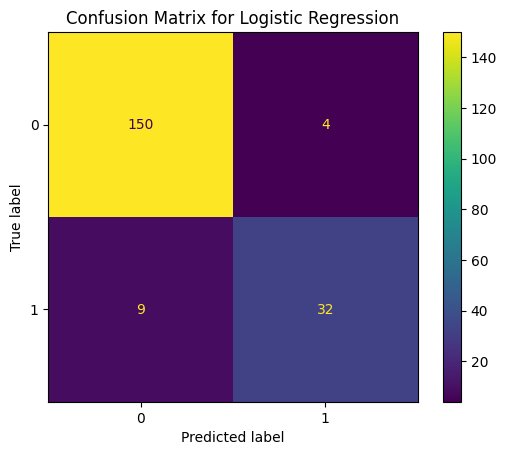

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
pred_adv = []
pred_dev = []

diffs = np.where(y_test != y_test_pred_log)[0]
diffs
for i in diffs:
  if y_test_pred_log[i] == 0:
      pred_dev.append(i)
  else:
    pred_adv.append(i)

# print(pred_dev)
print('Predicted Developing, Actually Advanced:')
for i in pred_dev:
  print(X_test.iloc[i].name)

# print(pred_adv)
print('\nPredicted Advanced, Actually Developing:')
for i in pred_adv:
  print(X_test.iloc[i].name)

Predicted Developing, Actually Advanced:
LVA 2020
IRL 2019
EST 2018
EST 2021
MLT 2020
USA 2021
MAC 2020
EST 2019
HRV 2017

Predicted Advanced, Actually Developing:
BRN 2021
OMN 2021
ABW 2021
OMN 2020


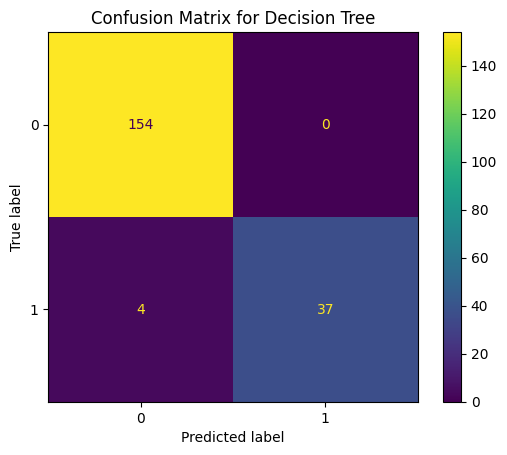

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp.plot()
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
pred_adv = []
pred_dev = []

diffs = np.where(y_test != y_test_pred_dt)[0]
diffs

for i in diffs:
  if y_test_pred_dt[i] == 0:
      pred_dev.append(i)
  else:
    pred_adv.append(i)

# print(pred_dev)
print('Predicted Developing, Actually Advanced:')
for i in pred_dev:
  print(X_test.iloc[i].name)

# print(pred_adv)
print('\nPredicted Advanced, Actually Developing:')
for i in pred_adv:
  print(X_test.iloc[i].name)

Predicted Developing, Actually Advanced:
GRC 2017
LUX 2019
HRV 2018
HRV 2017

Predicted Advanced, Actually Developing:


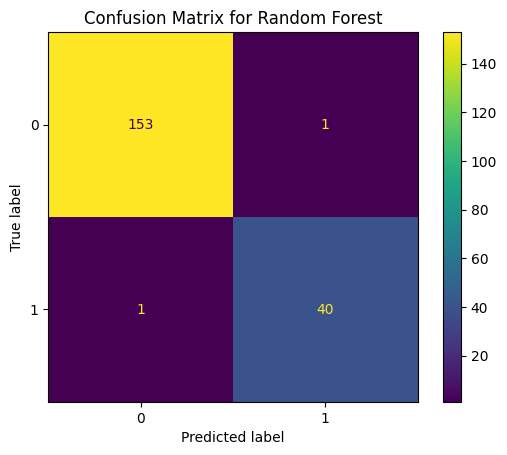

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [ ]:
pred_adv = []
pred_dev = []

diffs = np.where(y_test != y_test_pred_rf)[0]
diffs
for i in diffs:
  if y_test_pred_rf[i] == 0:
      pred_dev.append(i)
  else:
    pred_adv.append(i)

# print(pred_dev)
print('Predicted Developing, Actually Advanced:')
for i in pred_dev:
  print(X_test.iloc[i].name)

# print(pred_adv)
print('\nPredicted Advanced, Actually Developing:')
for i in pred_adv:
  print(X_test.iloc[i].name)

Predicted Developing, Actually Advanced:
HRV 2017

Predicted Advanced, Actually Developing:
OMN 2021


# Conclusion

We are very satisfied with the results of our project. We were able to achieve strong scores on our models and interesting results with our clustering algorithms that suggest a possible jumping off point for experts to look into. Overall, we were able to achieve what we set out to do.

# Workload Distribution

Work was distributed evenly amongst the two members

-David primarily worked on the supervised models.

-Jai primarily worked on the clustering models.